Fuente original: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page\
En Kaggle: https://www.kaggle.com/datasets/shuhengmo/uber-nyc-forhire-vehicles-trip-data-2021\
definición de datos: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_hvfhs.pdf

## Ejemplo prueba VTC NYC 2021

In [1]:
import pandas as pd

In [2]:

# Fuente original: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# En Kaggle: https://www.kaggle.com/datasets/shuhengmo/uber-nyc-forhire-vehicles-trip-data-2021
# definición de datos: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_hvfhs.pdf
# ## Ejemplo prueba VTC NCY 2021
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# prompt: modificar current working directory to '/content/drive/MyDrive/Colab Notebooks/TFM_en_colab/'
import os

# Change the working directory
os.chdir('/content/drive/MyDrive/Colab Notebooks/TFM_en_colab/')

In [4]:
path = 'Data/uber-nyc-forhire-vehicles-trip-data-2021/versions/1/'
# file = 'fhvhv_tripdata_2021-05.csv'
file = 'fhvhv_tripdata_2021-05.parquet.zip'

In [ ]:
# prompt: unzip path + file
import zipfile

with zipfile.ZipFile(path + file, 'r') as zip_ref:
    zip_ref.extractall(path)


In [5]:
import pyarrow.parquet as pq
trips = pq.read_table(path + 'fhvhv_tripdata_2021-05.parquet')
trips = trips.to_pandas()

In [31]:
import geopandas as gpd
# gdf = gpd.read_file('../Data/taxi_zones/taxi_zone_NYC_id.geojson')
gdf = gpd.read_file('Data/taxi_zones/taxi_zone_NYC_id.geojson')

#### Análisis NA values

In [11]:
trips_na = trips.isna().sum()

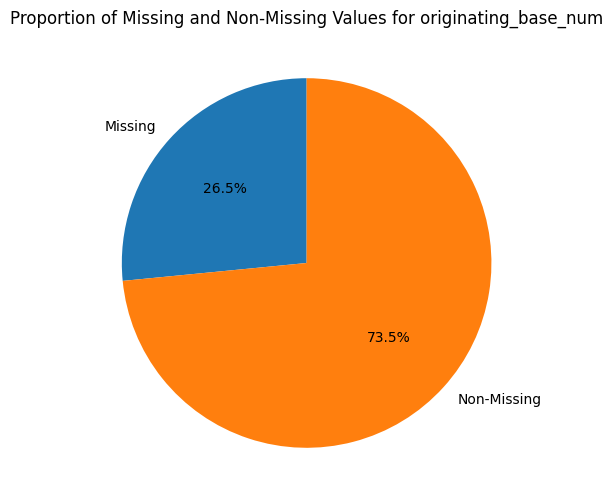

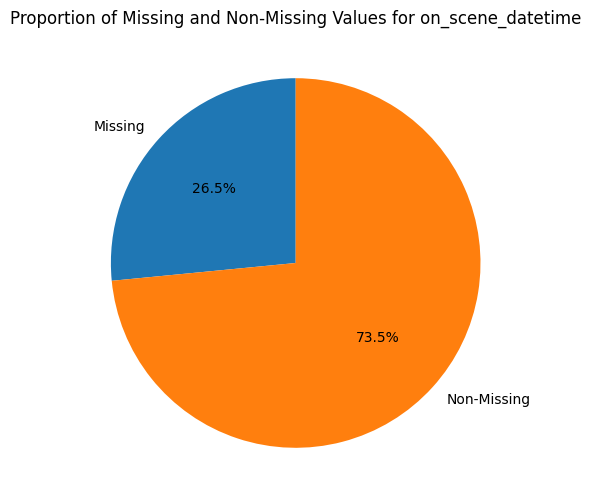

In [12]:
import matplotlib.pyplot as plt

# Variables to plot
variables = trips_na[trips_na > 0].index.tolist()

# Create pie charts
for var in variables:
    proportions = [trips_na[var] / len(trips), (len(trips) - trips_na[var]) / len(trips)]
    labels = ['Missing', 'Non-Missing']

    plt.figure(figsize=(6, 6))
    plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'Proportion of Missing and Non-Missing Values for {var}')
    plt.show()

#### Modificaciones en trips:
- Conversiones de tipo datetime

In [ ]:
datetime_columns = ['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime']
# new_trips.drop(columns=datetime_columns, inplace=True)

In [ ]:
# Convert request_datetime to datetime format if not already
trips['request_datetime'] = pd.to_datetime(trips['request_datetime'])

# Extract the hour from request_datetime
trips['request_hour'] = trips['request_datetime'].dt.hour

In [ ]:
trips['same_location'] = trips['PULocationID'] == trips['DOLocationID']

In [ ]:
# Map PULocationID to borough using gdf
# Ensure LocationID is unique in gdf
if not gdf['LocationID'].is_unique:
	gdf = gdf.drop_duplicates(subset='LocationID')

# Map PULocationID to borough using gdf
pulocation_to_borough = gdf.set_index('LocationID')['borough']

In [ ]:
trips['PUborough'] = trips['PULocationID'].map(pulocation_to_borough)
trips['DOborough'] = trips['DOLocationID'].map(pulocation_to_borough)
same_location_trips['borough'] = same_location_trips['DOLocationID'].map(pulocation_to_borough)

## Visualizaciones

In [ ]:
trips.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B02764               B02764   
1            HV0003               B02764               B02764   
2            HV0003               B02764               B02764   
3            HV0003               B02764               B02764   
4            HV0003               B02764               B02764   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2021-05-01 00:05:23 2021-05-01 00:06:08 2021-05-01 00:07:26   
1 2021-05-01 00:13:48 2021-05-01 00:17:28 2021-05-01 00:17:47   
2 2021-05-01 00:43:08 2021-05-01 00:47:11 2021-05-01 00:47:11   
3 2021-05-01 00:56:01 2021-05-01 00:58:04 2021-05-01 00:59:29   
4 2021-05-01 00:10:52 2021-05-01 00:15:57 2021-05-01 00:16:21   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  sales_tax  \
0 2021-05-01 00:14:44           246           234        1.22  ...       1.81   
1 2021-05-01 00:31:24           113           238        4.59  ...       5.58   
2 2021-05-01 00:55:24           236           262        1.37  ...       0.70   
3 2021-05-01 01:12:06           262           143        2.99  ...       1.25   
4 2021-05-01 00:59:12           263           265       31.16  ...       0.00   

   congestion_surcharge  airport_fee  tips  driver_pay  shared_request_flag  \
0                  2.75          0.0   0.0       10.66                    N   
1                  2.75          0.0   0.0       36.43                    N   
2                  2.75          0.0   0.0       10.16                    N   
3                  2.75          0.0   0.0        9.91                    N   
4                  0.00          0.0   0.0      100.00                    N   

   shared_match_flag  access_a_ride_flag  wav_request_flag wav_match_flag  
0                  N                                     N              N  
1                  N                                     N              N  
2                  N                                     N              N  
3                  N                                     N              N  
4                  N                                     N              N  

[5 rows x 24 columns]

### Visualización para cada variable

In [8]:
grouped_counts = trips.groupby('hvfhs_license_num')['hvfhs_license_num'].count()
print(grouped_counts)

hvfhs_license_num
HV0003    10808415
HV0004       96322
HV0005     3814434
Name: hvfhs_license_num, dtype: int64


In [9]:
# Define colors for each category
colors = ['black' if index == 'HV0003' else '#fc00ed' if index == 'HV0005' else 'blue' for index in grouped_counts.index]

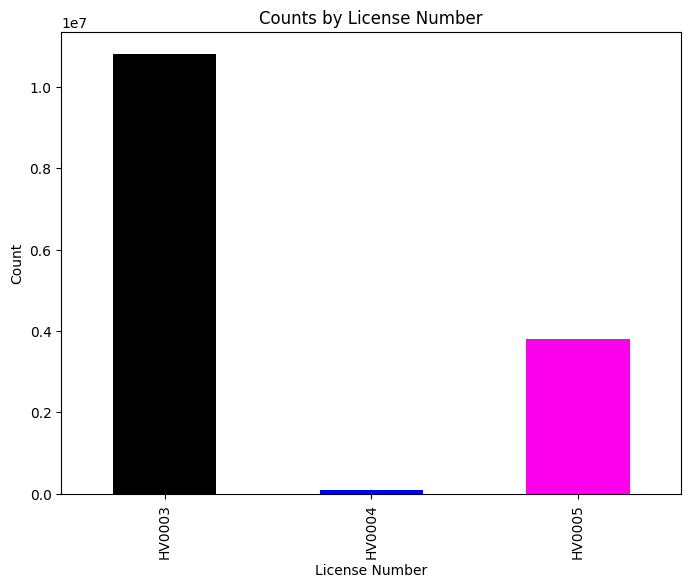

In [ ]:
# Plot the bar chart
grouped_counts.plot(kind='bar', color=colors, figsize=(8, 6))

# Add labels and title
plt.xlabel('License Number')
plt.ylabel('Count')
plt.title('Counts by License Number')
plt.show()

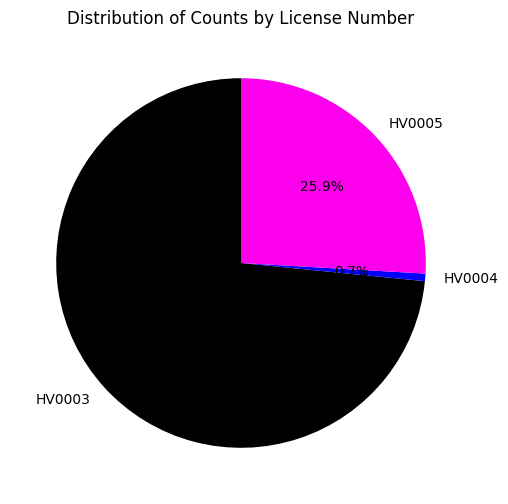

In [ ]:
# Generate a pie chart for grouped_counts
plt.figure(figsize=(6, 6))
plt.pie(grouped_counts, labels=grouped_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Counts by License Number')
plt.show()

Incluir diferencia entre 'dispatching_base_num' y 'originating_base_num' desagregado por hvfhs_license_num

In [ ]:
trips[['dispatching_base_num', 'originating_base_num']]

dispatching_base_num originating_base_num
0                      B02764               B02764
1                      B02764               B02764
2                      B02764               B02764
3                      B02764               B02764
4                      B02764               B02764
...                       ...                  ...
14719166               B02764               B02764
14719167               B02764               B02764
14719168               B02764               B02764
14719169               B02764               B02764
14719170               B02765               B02765

[14719171 rows x 2 columns]

In [ ]:
trips['dispatching_base_num'].value_counts()

dispatching_base_num
B02510    128932
B02764     45975
B02872     39348
B02875     31135
B02765     24097
B02869     19335
B02866     15548
B02887     14548
B02682     13611
B02864     12632
B02871     12587
B02878     11969
B02617     11190
B02883     11031
B02884     10713
B02882     10404
B02876      9756
B02835      9117
B02867      8622
B02879      8422
B02877      8406
B02888      7982
B02889      6462
B02836      5704
B02880      5435
B02395      4432
B02870      3998
B02865      3747
B02800      3205
B02512      1452
B02844       157
B03136        48
Name: count, dtype: int64

In [ ]:
trips[['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime']].sort_values(by='request_datetime')

request_datetime    on_scene_datetime      pickup_datetime  \
168160  2021-04-30 23:28:12                  NaN  2021-05-01 00:00:30   
72607   2021-04-30 23:35:55                  NaN  2021-05-01 00:03:42   
470963  2021-04-30 23:46:16                  NaN  2021-05-01 00:04:50   
179936  2021-04-30 23:49:39                  NaN  2021-05-01 00:02:53   
52532   2021-04-30 23:50:11  2021-05-01 00:00:30  2021-05-01 00:00:30   
...                     ...                  ...                  ...   
17461   2021-05-31 23:55:00                  NaN  2021-05-31 23:40:07   
369721  2021-05-31 23:55:49  2021-05-31 23:57:32  2021-05-31 23:57:32   
129482  2021-05-31 23:56:28                  NaN  2021-05-31 23:59:58   
25634   2021-05-31 23:58:11                  NaN  2021-05-31 23:59:33   
15408   2021-06-01 00:00:00                  NaN  2021-05-31 23:45:00   

           dropoff_datetime  
168160  2021-05-01 00:14:00  
72607   2021-05-01 00:14:17  
470963  2021-05-01 00:13:41  
179936  2021-05-01 00:11:50  
52532   2021-05-01 00:15:14  
...                     ...  
17461   2021-06-01 00:39:26  
369721  2021-06-01 00:57:34  
129482  2021-06-01 00:13:52  
25634   2021-06-01 00:16:48  
15408   2021-05-31 23:48:31  

[500000 rows x 4 columns]

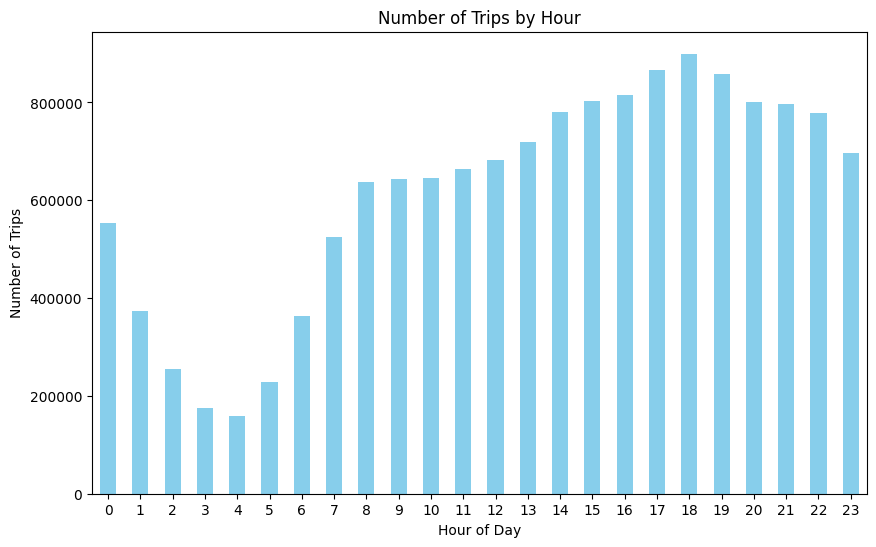

In [13]:
# Convert request_datetime to datetime format if not already
trips['request_datetime'] = pd.to_datetime(trips['request_datetime'])

# Extract the hour from request_datetime
trips['request_hour'] = trips['request_datetime'].dt.hour

# Group by hour and count the number of trips
trips_by_hour = trips.groupby('request_hour').size()

# Plot the histogram
plt.figure(figsize=(10, 6))
trips_by_hour.plot(kind='bar', color='skyblue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour')
plt.xticks(rotation=0)
plt.show()


In [ ]:
trips[['PULocationID', 'DOLocationID']].value_counts()

PULocationID  DOLocationID
76            76              1684
39            39               987
132           265              983
61            61               896
26            26               820
                              ... 
211           109                1
133           81                 1
21            23                 1
              20                 1
1             75                 1
Name: count, Length: 35733, dtype: int64

In [14]:
trips['same_location'] = trips['PULocationID'] == trips['DOLocationID']

In [ ]:
trips['same_location'].value_counts()

same_location
False    13781007
True       938164
Name: count, dtype: int64

In [19]:
same_location_trips = trips.loc[trips['PULocationID'] == trips['DOLocationID']]

In [20]:
same_location_trips['DOLocationID'].value_counts()

DOLocationID
76     49821
39     29227
61     26106
26     23671
14     19429
       ...  
207        3
111        2
8          2
1          2
2          1
Name: count, Length: 259, dtype: int64

Representación en mapas

In [ ]:
len(trips['DOLocationID'].unique())

262

In [15]:
gdf.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough taxi_zone_lookup_LocationID  \
0            EWR                        None   
1         Queens                        None   
2          Bronx                        None   
3      Manhattan                        None   
4  Staten Island                        None   

                                            geometry  
0  MULTIPOLYGON (((933100.918 192536.086, 933091....  
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2  MULTIPOLYGON (((1026308.77 256767.698, 1026495...  
3  MULTIPOLYGON (((992073.467 203714.076, 992068....  
4  MULTIPOLYGON (((935843.31 144283.336, 936046.5...

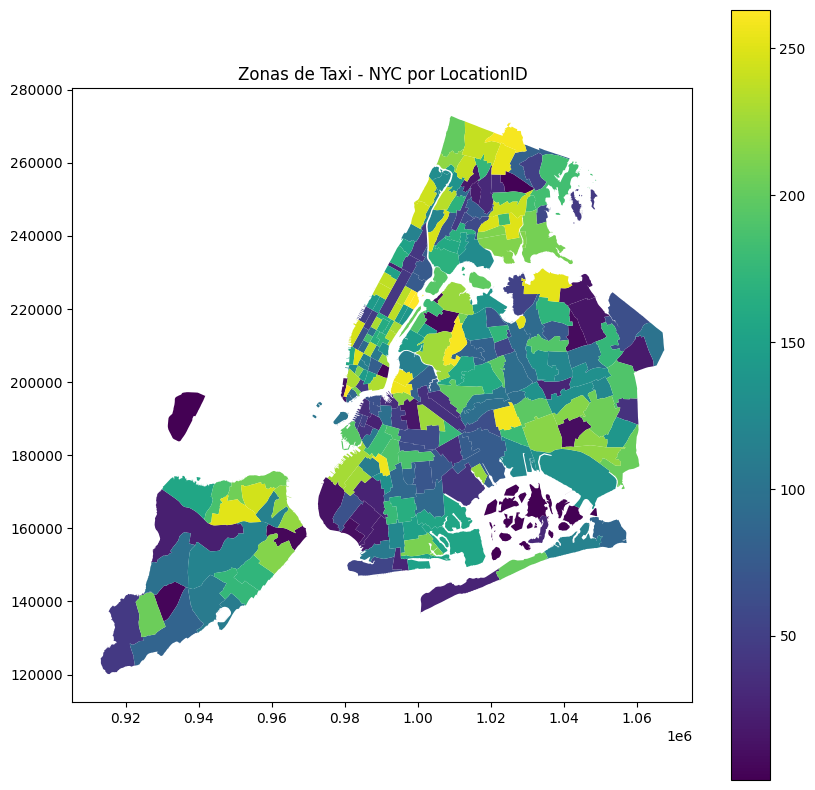

In [ ]:
gdf.plot(column="LocationID", legend=True, figsize=(10, 10))
plt.title("Zonas de Taxi - NYC por LocationID")
plt.show()

Análisis:
- SameLocation
- Origen: PULocationID
- Destion: DOLocationID

In [ ]:
gdf.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough taxi_zone_lookup_LocationID  \
0            EWR                        None   
1         Queens                        None   
2          Bronx                        None   
3      Manhattan                        None   
4  Staten Island                        None   

                                            geometry  
0  MULTIPOLYGON (((933100.918 192536.086, 933091....  
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2  MULTIPOLYGON (((1026308.77 256767.698, 1026495...  
3  MULTIPOLYGON (((992073.467 203714.076, 992068....  
4  MULTIPOLYGON (((935843.31 144283.336, 936046.5...

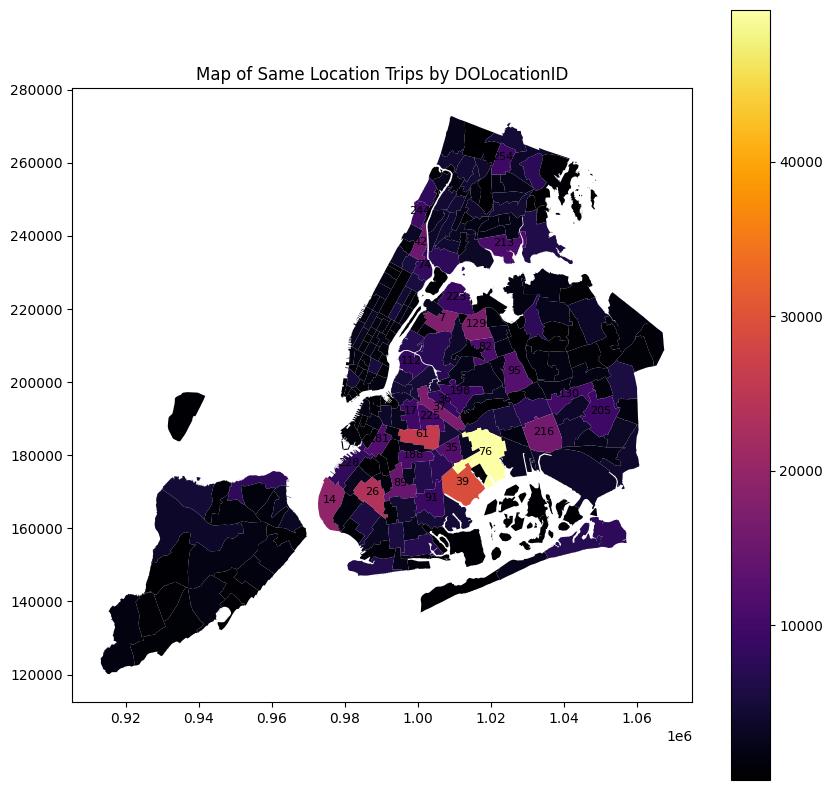

In [ ]:
# Filter gdf to include only the DOLocationIDs present in same_location_trips
filtered_gdf = gdf[gdf['LocationID'].isin(same_location_trips['DOLocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = same_location_trips['DOLocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='inferno', figsize=(10, 10))
plt.title("Map of Same Location Trips by DOLocationID")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(30)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

In [ ]:
trips['PULocationID'].value_counts().head()

PULocationID
61     232717
79     211844
76     193444
37     180506
132    171889
Name: count, dtype: int64

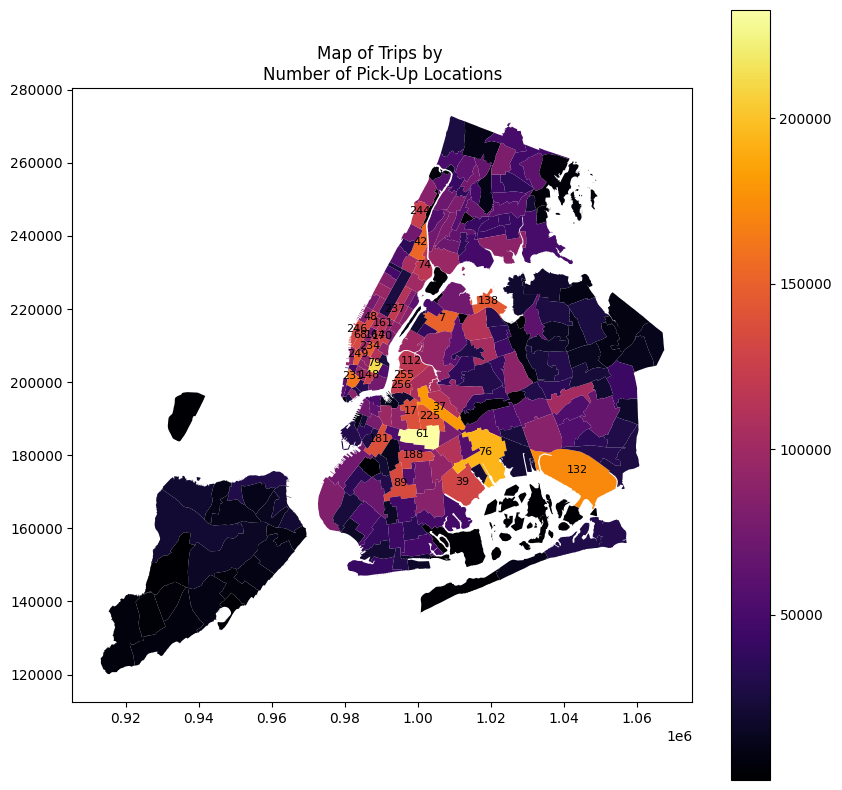

In [ ]:
# Filter gdf to include only the DOLocationIDs present in same_location_trips
filtered_gdf = gdf[gdf['LocationID'].isin(trips['PULocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = trips['PULocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='inferno', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Pick-Up Locations")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(30)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

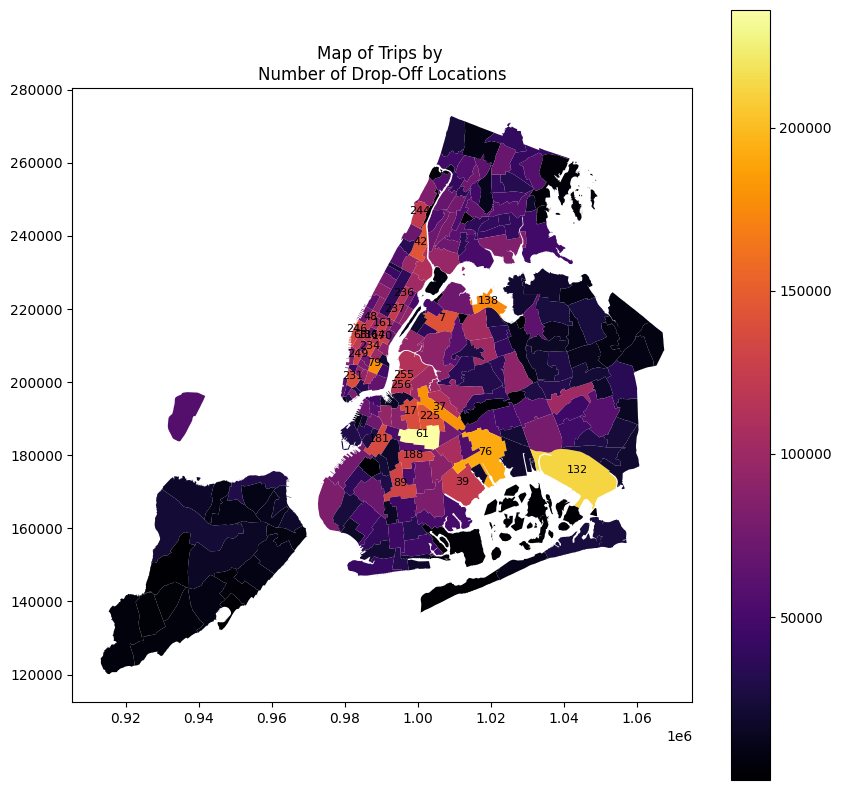

In [ ]:
# Filter gdf to include only the DOLocationIDs present in same_location_trips
filtered_gdf = gdf[gdf['LocationID'].isin(trips['DOLocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = trips['DOLocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='inferno', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Drop-Off Locations")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(30)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

Otros gráficos:
- Trayectos más frecuentes

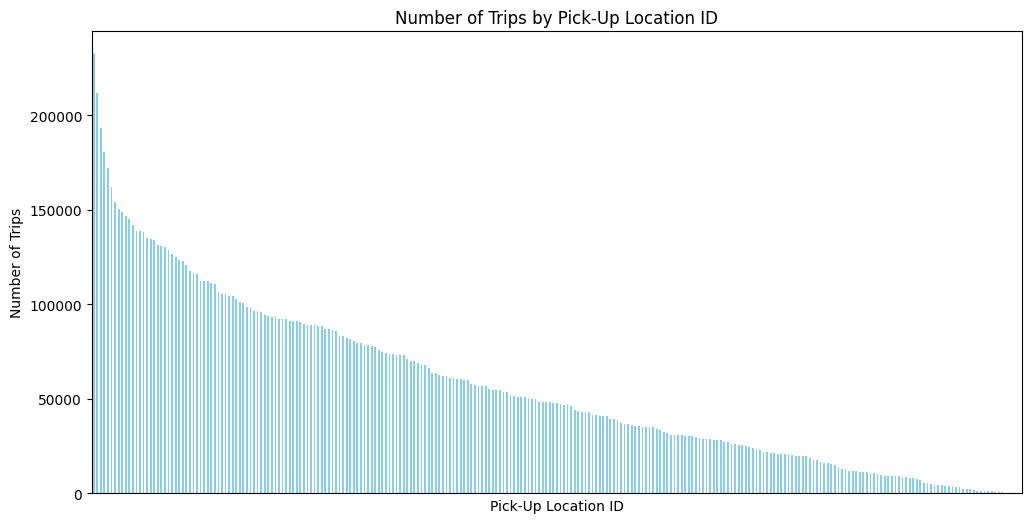

In [ ]:
# Generate a bar plot for trips['PULocationID'] ordered by value_counts()
pulocation_counts = trips['PULocationID'].value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 6))
pulocation_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Pick-Up Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Pick-Up Location ID')

# Remove x-ticks
plt.xticks([])

plt.show()

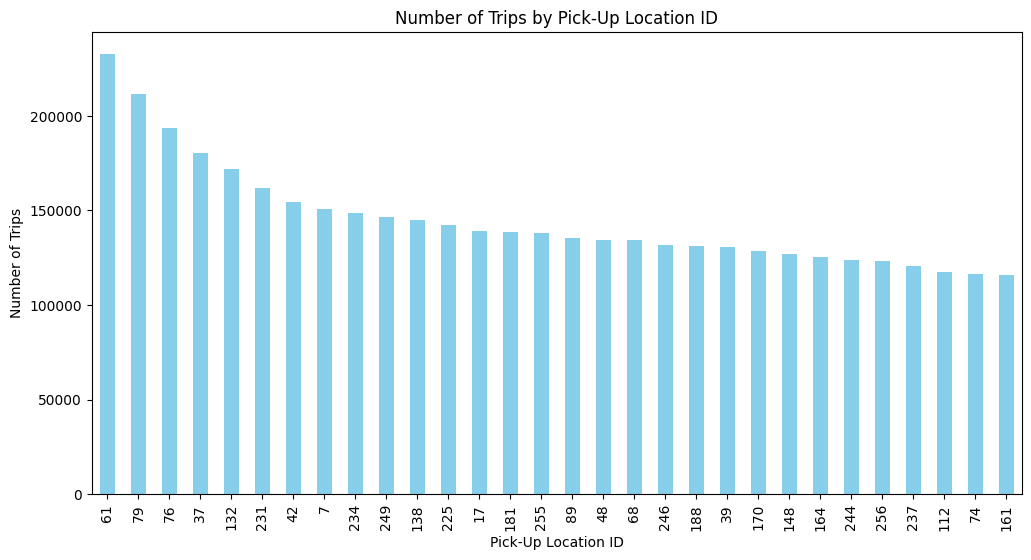

In [ ]:
# Generate a bar plot for trips['PULocationID'] ordered by value_counts()
pulocation_counts = trips['PULocationID'].value_counts().head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
pulocation_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Pick-Up Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Pick-Up Location ID')

# Remove x-ticks
# plt.xticks([])

plt.show()

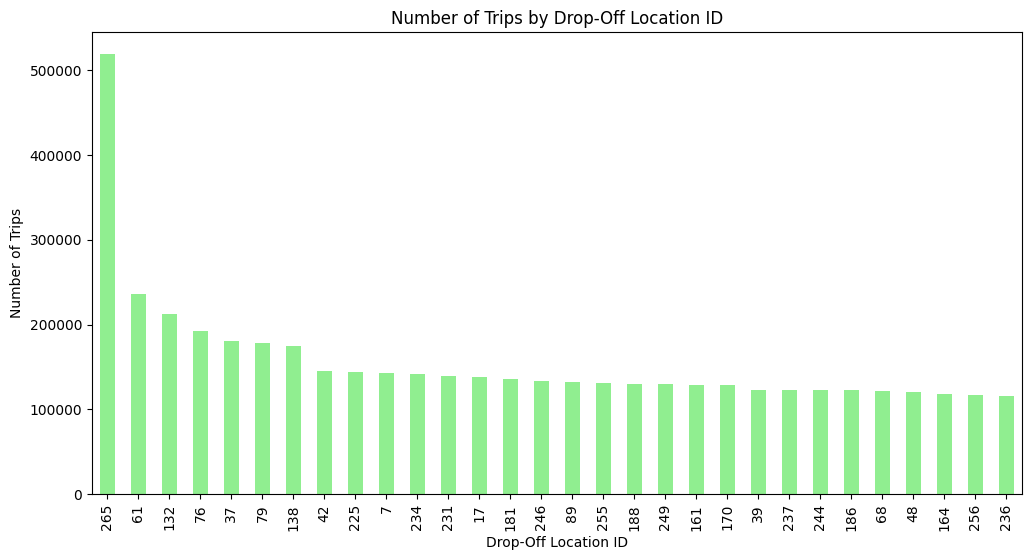

In [ ]:
# Generate a bar plot for trips['PULocationID'] ordered by value_counts()
dolocation_counts = trips['DOLocationID'].value_counts().head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
dolocation_counts.plot(kind='bar', color='lightgreen')

# Add labels and title
plt.xlabel('Drop-Off Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Drop-Off Location ID')

# Remove x-ticks
# plt.xticks([])

plt.show()

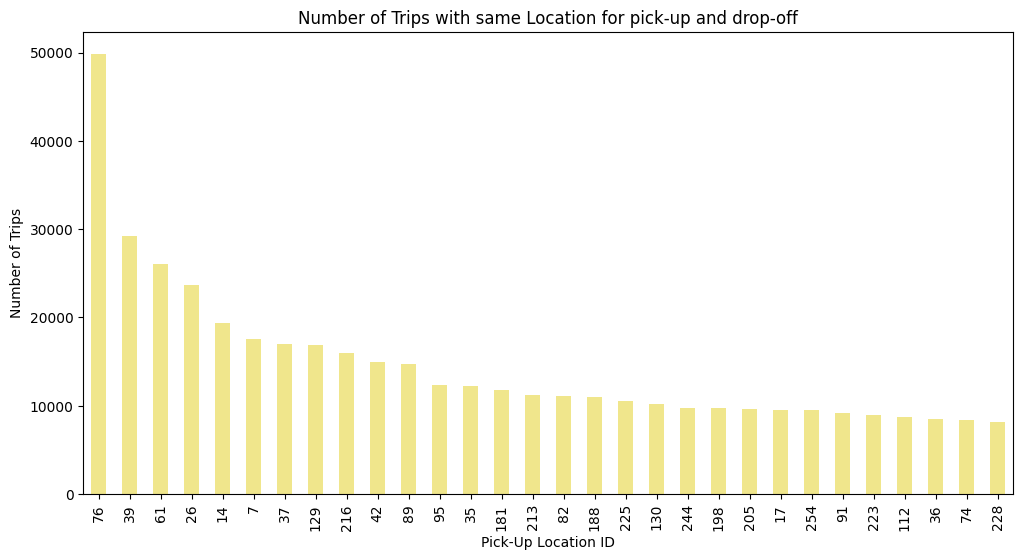

In [ ]:
# Generate a bar plot for trips['PULocationID'] ordered by value_counts()
sametrip_counts = same_location_trips['DOLocationID'].value_counts().head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sametrip_counts.plot(kind='bar', color='khaki')

# Add labels and title
plt.xlabel('Pick-Up Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips with same Location for pick-up and drop-off')

# Remove x-ticks
# plt.xticks([])

plt.show()

Agrupar barras por Boroughs
- ¿Cuanto representa trips with same origin/destination sobre el total de Drop-Offs o Pick-Ups?
- Mapas por franjas horarias

In [32]:
# Map PULocationID to borough using gdf
# Ensure LocationID is unique in gdf
if not gdf['LocationID'].is_unique:
	gdf = gdf.drop_duplicates(subset='LocationID')

# Map PULocationID to borough using gdf
pulocation_to_borough = gdf.set_index('LocationID')['borough']


In [21]:
trips['PUborough'] = trips['PULocationID'].map(pulocation_to_borough)
trips['DOborough'] = trips['DOLocationID'].map(pulocation_to_borough)
same_location_trips['borough'] = same_location_trips['DOLocationID'].map(pulocation_to_borough)

<ipython-input-21-ff32a428d1a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_location_trips['borough'] = same_location_trips['DOLocationID'].map(pulocation_to_borough)


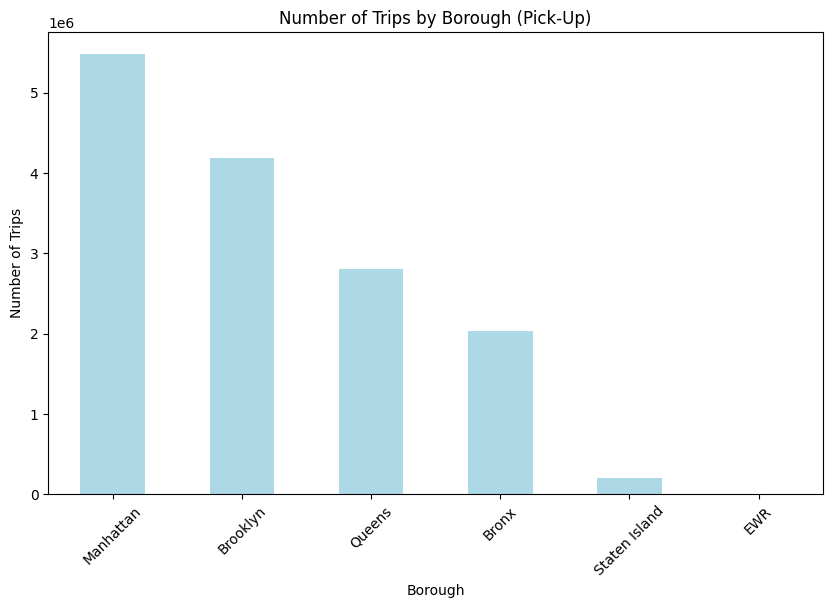

In [ ]:
# Group by borough and count the number of trips
borough_counts = trips['PUborough'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
borough_counts.plot(kind='bar', color='lightblue')

# Add labels and title
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Borough (Pick-Up)')
plt.xticks(rotation=45)
plt.show()

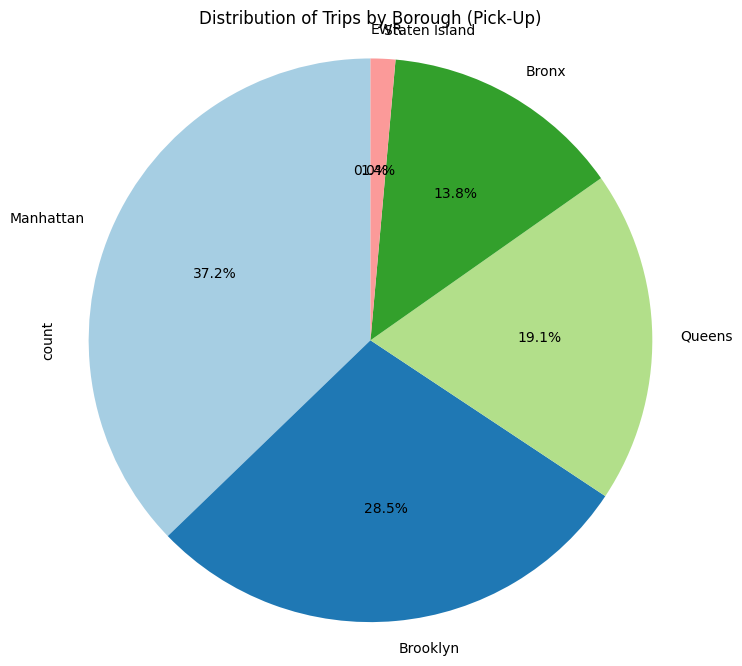

In [ ]:
# Generate a pie chart for borough_counts
borough_counts = trips['PUborough'].value_counts()

plt.figure(figsize=(8, 8))
borough_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Distribution of Trips by Borough (Pick-Up)')

# Ensure the pie chart is a circle
plt.axis('equal')

plt.show()

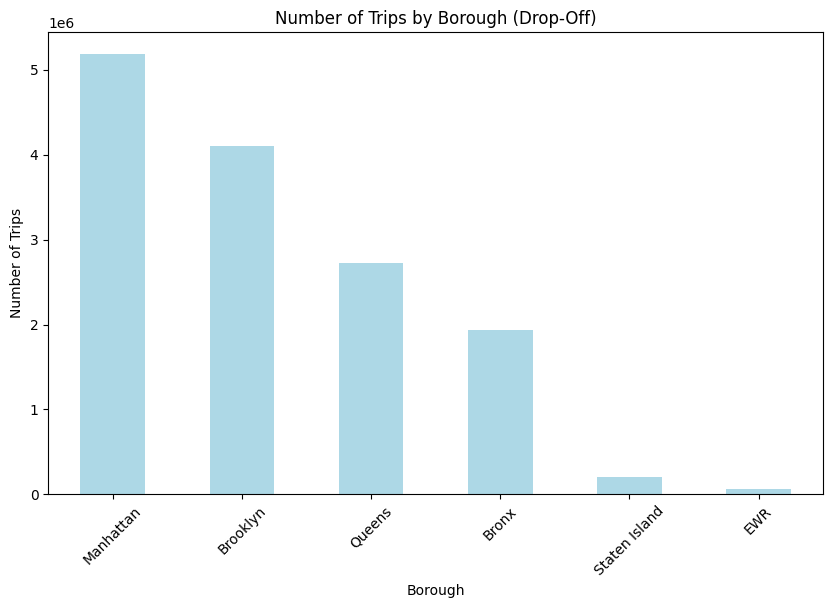

In [ ]:
# Group by borough and count the number of trips
borough_counts = trips['DOborough'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
borough_counts.plot(kind='bar', color='lightblue')

# Add labels and title
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Borough (Drop-Off)')
plt.xticks(rotation=45)
plt.show()

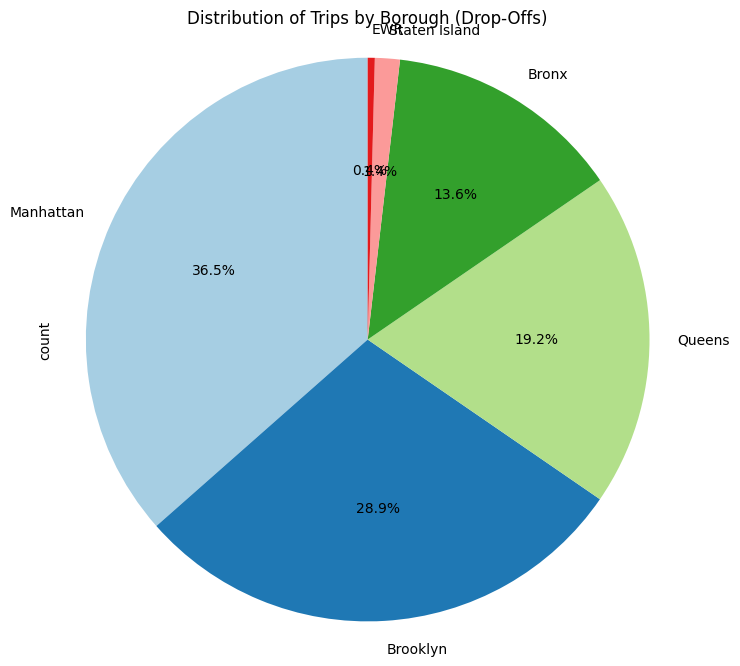

In [ ]:
# Generate a pie chart for borough_counts
borough_counts = trips['DOborough'].value_counts()

plt.figure(figsize=(8, 8))
borough_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Distribution of Trips by Borough (Drop-Offs)')

# Ensure the pie chart is a circle
plt.axis('equal')

plt.show()

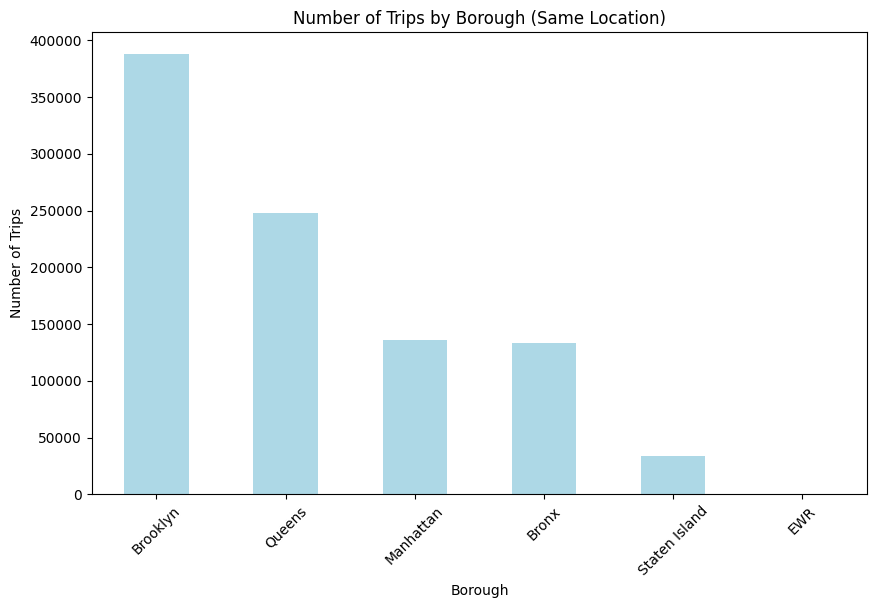

In [ ]:
# Group by borough and count the number of trips
borough_counts = same_location_trips['borough'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
borough_counts.plot(kind='bar', color='lightblue')

# Add labels and title
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Borough (Same Location)')
plt.xticks(rotation=45)
plt.show()

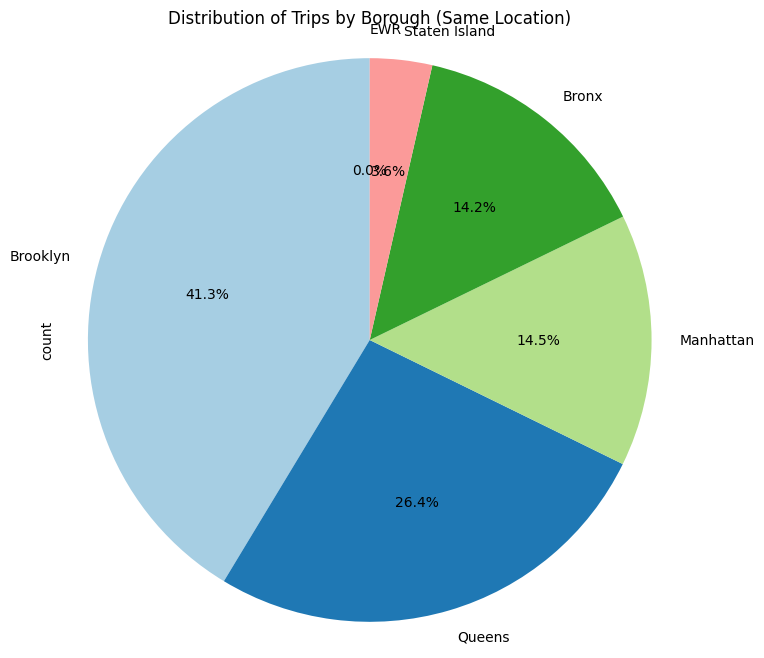

In [ ]:
# Generate a pie chart for borough_counts
borough_counts = same_location_trips['borough'].value_counts()

plt.figure(figsize=(8, 8))
borough_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Distribution of Trips by Borough (Same Location)')

# Ensure the pie chart is a circle
plt.axis('equal')

plt.show()

In [ ]:
trips[['trip_miles','trip_time']]

trip_miles  trip_time
0            2.019        594
1            1.479        444
2            2.010        589
3            1.619        779
4            0.720        221
...            ...        ...
499995       1.799        610
499996       0.000       1039
499997       0.970        395
499998       2.480       1004
499999       2.460       1023

[500000 rows x 2 columns]

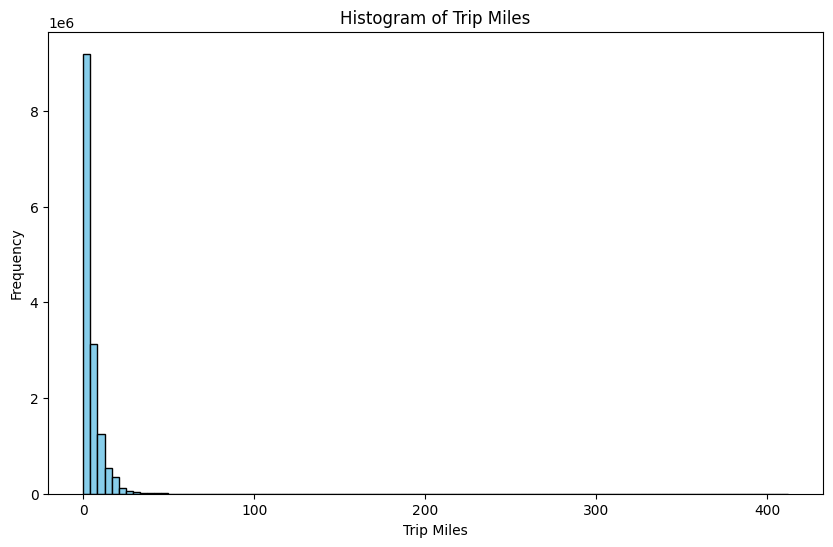

In [ ]:
# Generate a histogram for 'trip_miles' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['trip_miles'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Miles')

plt.show()

In [ ]:
max(trips['trip_miles'])

412.13

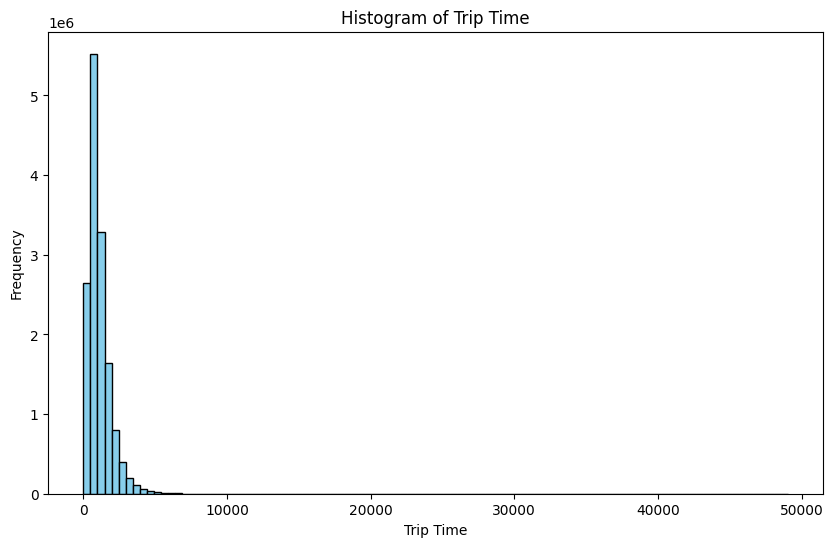

In [ ]:
# Generate a histogram for 'trip_miles' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['trip_time'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Trip Time')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Time')

plt.show()

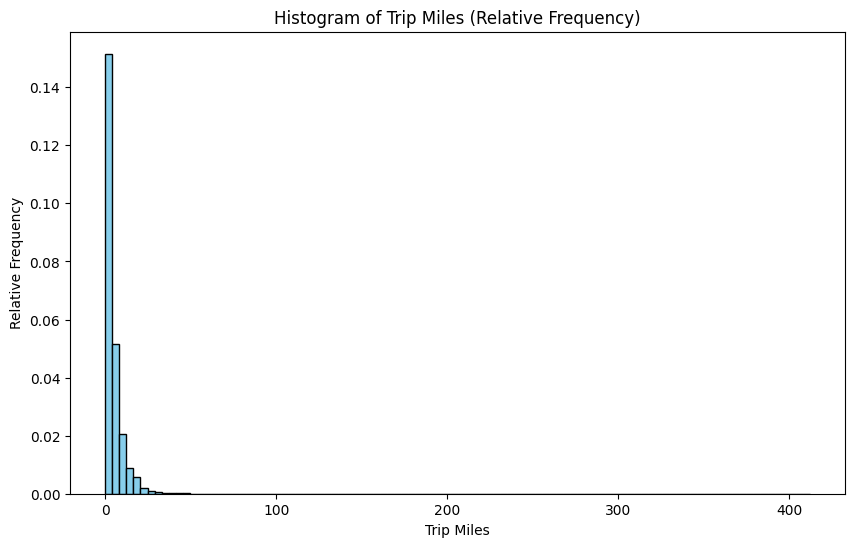

In [ ]:
# Generate a histogram for 'trip_miles' with 100 bins and relative frequency
plt.figure(figsize=(10, 6))
plt.hist(trips['trip_miles'], bins=100, color='skyblue', edgecolor='black', density=True)

# Add labels and title
plt.xlabel('Trip Miles')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Trip Miles (Relative Frequency)')

plt.show()

In [22]:
trips['trip_miles'].describe()

count    1.471917e+07
mean     4.843593e+00
std      5.493553e+00
min      0.000000e+00
25%      1.650000e+00
50%      3.014000e+00
75%      5.956000e+00
max      4.121300e+02
Name: trip_miles, dtype: float64

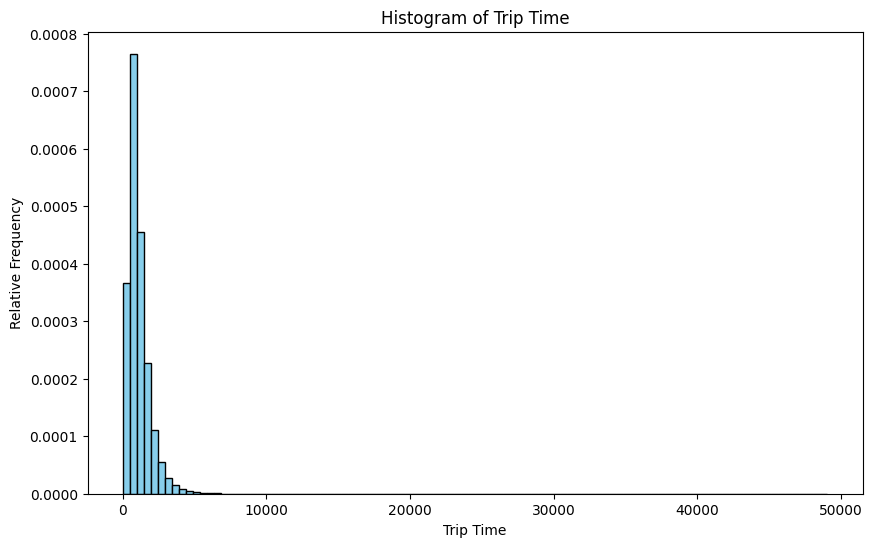

In [ ]:
# Generate a histogram for 'trip_miles' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['trip_time'], bins=100, color='skyblue', edgecolor='black', density=True)

# Add labels and title
plt.xlabel('Trip Time')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Trip Time')

plt.show()

In [ ]:
max(trips['trip_time'])

49052

El tiempo máximo de carrera es 49052, revisar cuanto es la distancia recorrida.\
También revisar el máximo de distancia recorrida. Revisar si tienen sentido.

En la sección "Outliers" -> Tener en cuenta.

In [ ]:
trips['trip_time'].describe()

count    1.471917e+07
mean     1.093808e+03
std      7.710549e+02
min      0.000000e+00
25%      5.740000e+02
50%      8.960000e+02
75%      1.387000e+03
max      4.905200e+04
Name: trip_time, dtype: float64

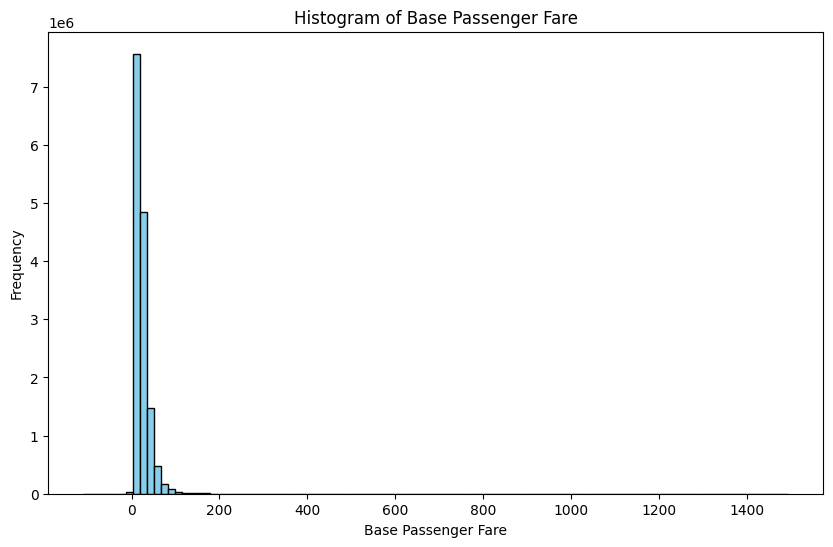

In [ ]:
# Generate a histogram for 'base_passenger_fare' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['base_passenger_fare'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Base Passenger Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Base Passenger Fare')

plt.show()

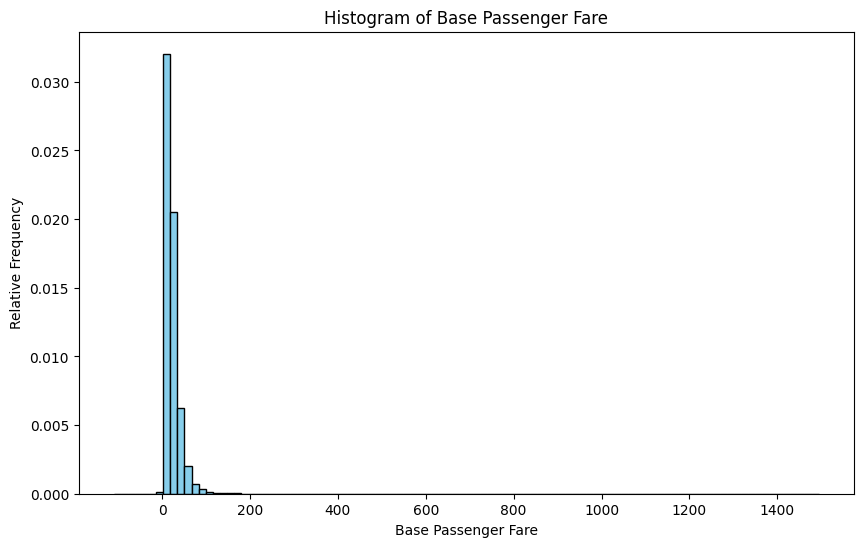

In [ ]:
# Generate a histogram for 'base_passenger_fare' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['base_passenger_fare'], bins=100, color='skyblue', edgecolor='black', density=True)

# Add labels and title
plt.xlabel('Base Passenger Fare')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Base Passenger Fare')

plt.show()

In [ ]:
trips['base_passenger_fare'].describe()

count    1.471917e+07
mean     2.264384e+01
std      1.731347e+01
min     -1.097100e+02
25%      1.174000e+01
50%      1.807000e+01
75%      2.792000e+01
max      1.493980e+03
Name: base_passenger_fare, dtype: float64

In [ ]:
from plotnine import ggplot, aes, geom_histogram, facet_wrap, theme_538, labs
import pandas as pd

# Reshape the data into long format
variables = ['tips', 'tolls', 'bcf', 'congestion_surcharge', 'sales_tax']
long_data = trips.melt(value_vars=variables, var_name='Variable', value_name='Value')

# Create the facet grid plot
plot = (
    ggplot(long_data, aes(x='Value')) +
    geom_histogram(bins=30, fill='skyblue', color='black') +
    facet_wrap('~Variable', scales='free') +
    theme_538() +
    labs(title='Distribution of Selected Variables', x='Value', y='Frequency')
)


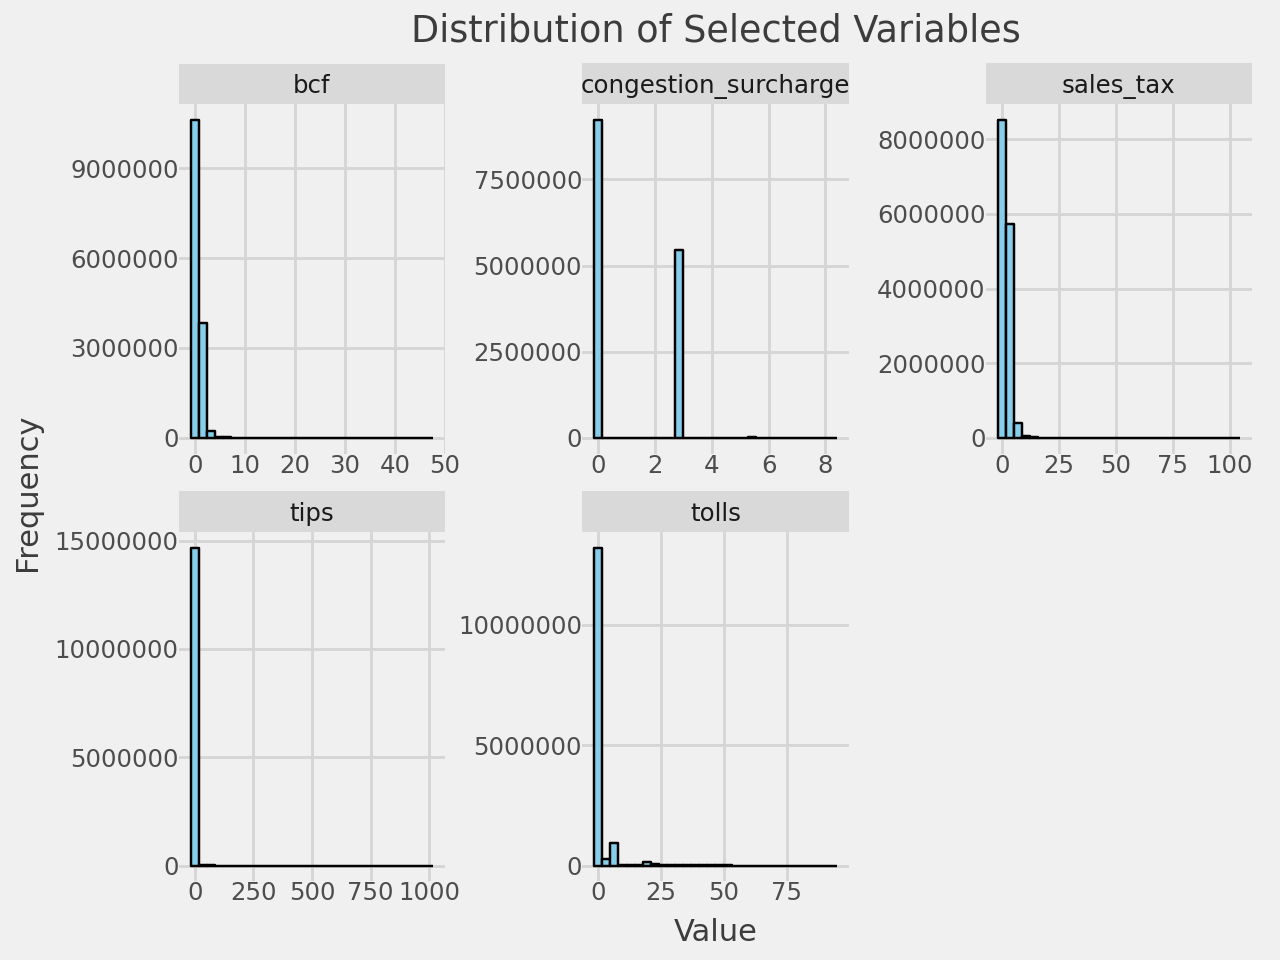

In [ ]:
plot

Revisar valores de "congestion_surcharge"

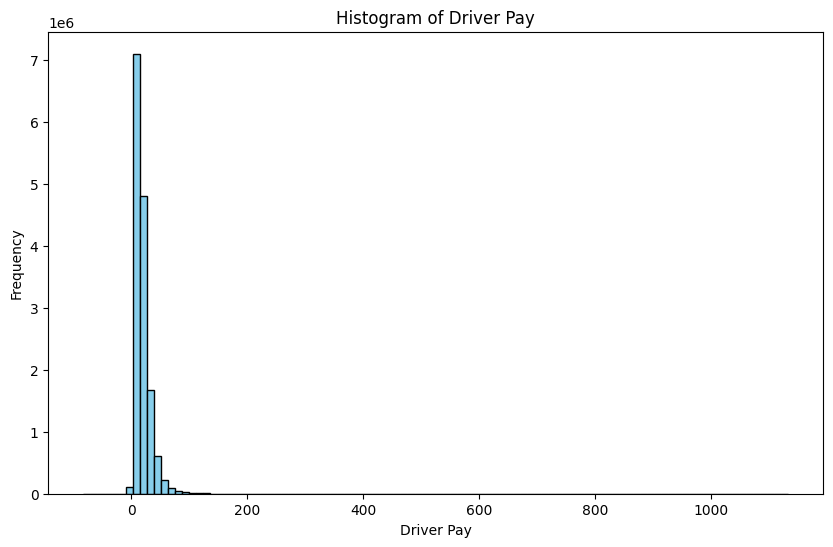

In [ ]:
# Generate a histogram for 'base_passenger_fare' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['driver_pay'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Driver Pay')
plt.ylabel('Frequency')
plt.title('Histogram of Driver Pay')

plt.show()

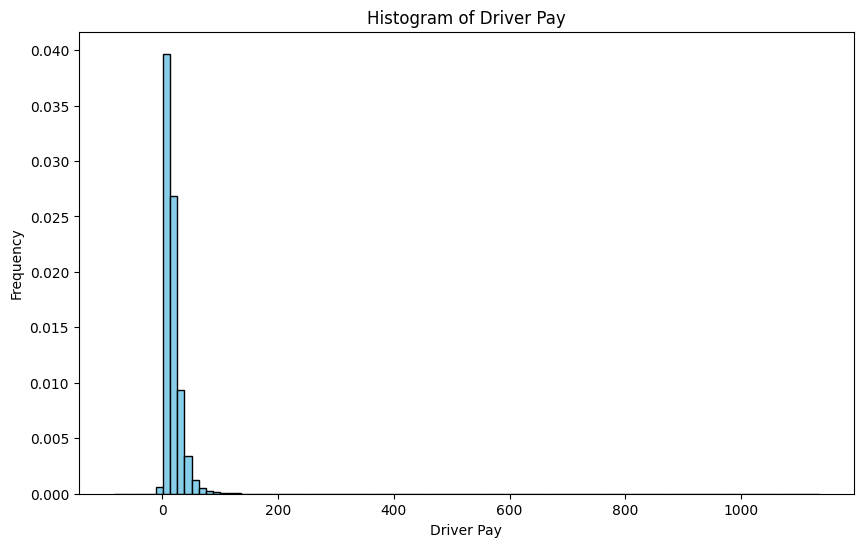

In [ ]:
# Generate a histogram for 'base_passenger_fare' with 100 bins
plt.figure(figsize=(10, 6))
plt.hist(trips['driver_pay'], bins=100, color='skyblue', edgecolor='black', density=True)

# Add labels and title
plt.xlabel('Driver Pay')
plt.ylabel('Frequency')
plt.title('Histogram of Driver Pay')

plt.show()

In [ ]:
trips['driver_pay'].describe()

count    1.471917e+07
mean     1.820628e+01
std      1.388465e+01
min     -8.298000e+01
25%      9.220000e+00
50%      1.457000e+01
75%      2.282000e+01
max      1.133490e+03
Name: driver_pay, dtype: float64

Revisar posibles outliers

In [ ]:
trips['shared_request_flag'].value_counts()

shared_request_flag
N    14711146
Y        8025
Name: count, dtype: int64

In [ ]:
trips['shared_match_flag'].value_counts()

shared_match_flag
N    14714547
Y        4624
Name: count, dtype: int64

In [ ]:
trips['access_a_ride_flag'].value_counts()

access_a_ride_flag
     10808415
N     3910756
Name: count, dtype: int64

In [ ]:
trips['wav_request_flag'].value_counts()

wav_request_flag
N    14696991
Y       22180
Name: count, dtype: int64

In [ ]:
trips['wav_match_flag'].value_counts()

wav_match_flag
N    13959276
Y      759895
Name: count, dtype: int64

### Visualización entre pares de variables

Relación entre variables y empresa VTC

In [23]:
trips_copy = trips.copy()

hvfhs_license_num, hvfhs_license_num, originating_base_num\
- request_datetime, on_scene_datetime, pickup_datetime, dropoff_datetime
- PULocationID, DOLocationID
- trip_miles, trip_time
- base_passenger_fare, tolls, bcf, sales_tax, congestion_surcharge, tips, driver_pay
- shared_request_flag, shared_match_flag, access_a_ride_flag, wav_request_flag, wav_match_flag

In [ ]:
colors

['black', 'blue', '#fc00ed']

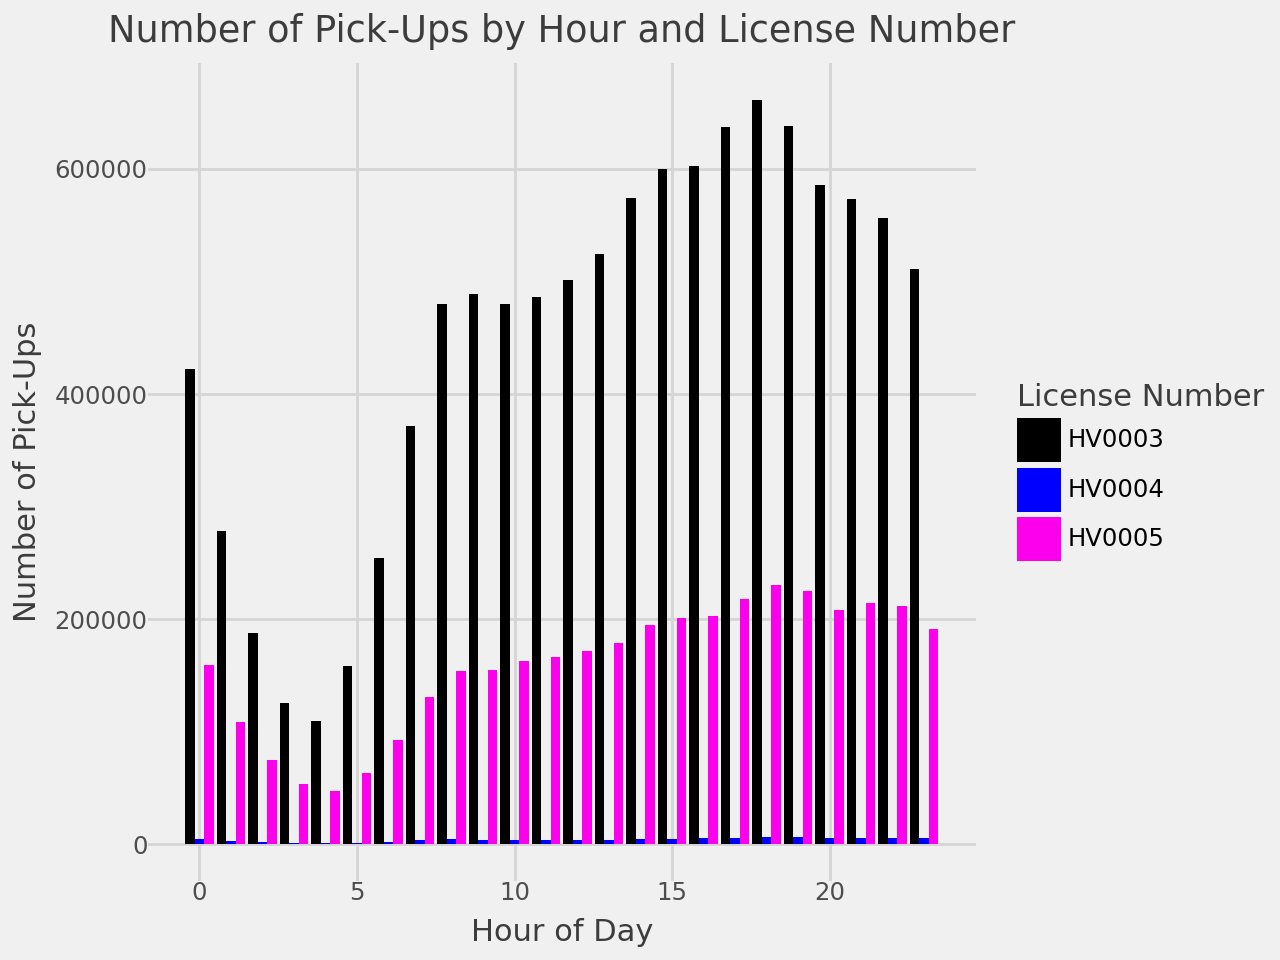

In [24]:
from plotnine import ggplot, aes, geom_col, labs, scale_fill_manual, theme_538

# Ensure pickup_datetime is in datetime format
trips_copy['pickup_datetime'] = pd.to_datetime(trips_copy['pickup_datetime'])

# Extract the hour from pickup_datetime
trips_copy['pickup_hour'] = trips_copy['pickup_datetime'].dt.hour

# Group by hvfhs_license_num and pickup_hour, and count the number of trips
hourly_counts = trips_copy.groupby(['hvfhs_license_num', 'pickup_hour']).size().reset_index(name='count')

# Define a mapping of license numbers to colors
license_colors = dict(zip(hourly_counts['hvfhs_license_num'].unique(), colors))

# Create the plot
plot = (
    ggplot(hourly_counts, aes(x='pickup_hour', y='count', fill='hvfhs_license_num')) +
    geom_col(position='dodge') +
    scale_fill_manual(values=license_colors) +
    labs(
        title='Number of Pick-Ups by Hour and License Number',
        x='Hour of Day',
        y='Number of Pick-Ups',
        fill='License Number'
    ) +
    theme_538()
)

plot

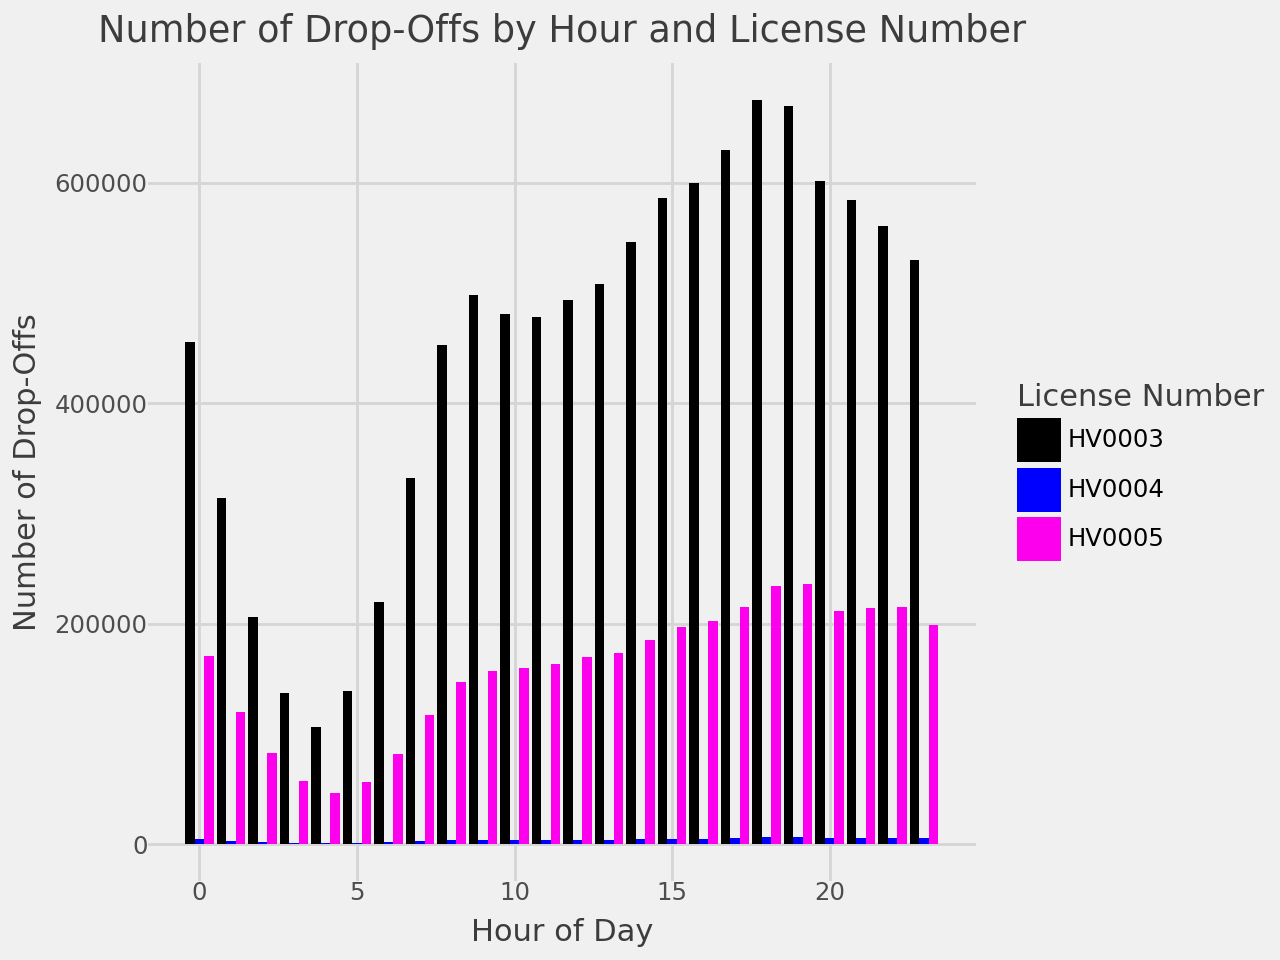

In [ ]:
# Ensure dropoff_datetime is in datetime format
trips_copy['dropoff_datetime'] = pd.to_datetime(trips_copy['dropoff_datetime'])

# Extract the hour from dropoff_datetime
trips_copy['dropoff_hour'] = trips_copy['dropoff_datetime'].dt.hour

# Group by hvfhs_license_num and pickup_hour, and count the number of trips
hourly_counts = trips_copy.groupby(['hvfhs_license_num', 'dropoff_hour']).size().reset_index(name='count')

# Define a mapping of license numbers to colors
license_colors = dict(zip(hourly_counts['hvfhs_license_num'].unique(), colors))

# Create the plot
plot = (
    ggplot(hourly_counts, aes(x='dropoff_hour', y='count', fill='hvfhs_license_num')) +
    geom_col(position='dodge') +
    scale_fill_manual(values=license_colors) +
    labs(
        title='Number of Drop-Offs by Hour and License Number',
        x='Hour of Day',
        y='Number of Drop-Offs',
        fill='License Number'
    ) +
    theme_538()
)

plot

PULocationID, DOLocationID

In [ ]:
# Group by 'hvfhs_license_num' and get the top 5 PULocationID for each group
top_pulocation_ids = trips_copy.groupby('hvfhs_license_num')['PULocationID'].value_counts().groupby(level=0).head(5)

# Print the result
print(top_pulocation_ids)

hvfhs_license_num  PULocationID
HV0003             61              160552
                   79              151694
                   76              145281
                   37              126772
                   231             124817
HV0004             166               4352
                   79                2224
                   41                2036
                   74                2014
                   140               1962
HV0005             61               71119
                   79               57926
                   132              54182
                   138              54008
                   37               52981
Name: count, dtype: int64


In [ ]:
# Group by 'hvfhs_license_num' and get the top 5 PULocationID for each group
top_dolocation_ids = trips_copy.groupby('hvfhs_license_num')['DOLocationID'].value_counts().groupby(level=0).head(5)

# Print the result
print(top_dolocation_ids)

hvfhs_license_num  DOLocationID
HV0003             265             13050
                   61               5448
                   132              5281
                   76               4871
                   138              4290
HV0004             166               143
                   13                 91
                   79                 65
                   24                 64
                   132                62
HV0005             265              4700
                   61               2451
                   37               1772
                   79               1750
                   132              1687
Name: count, dtype: int64


In [ ]:
# Filter data for PULocationID == 37
pulocation_37 = top_pulocation_ids.loc[(slice(None), 37)].reset_index()
pulocation_37.columns = ['hvfhs_license_num', 'count']

# Ensure all license numbers are included
all_license_nums = ['HV0003', 'HV0004', 'HV0005']
pulocation_37 = pulocation_37.set_index('hvfhs_license_num').reindex(all_license_nums, fill_value=0).reset_index()

# Create proportions for the pie chart
proportions = pulocation_37['count'] / pulocation_37['count'].sum()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(proportions, labels=pulocation_37['hvfhs_license_num'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Trips for Bushwick South, Brooklyn (37)')
plt.show()

NameError: name 'top_pulocation_ids' is not defined

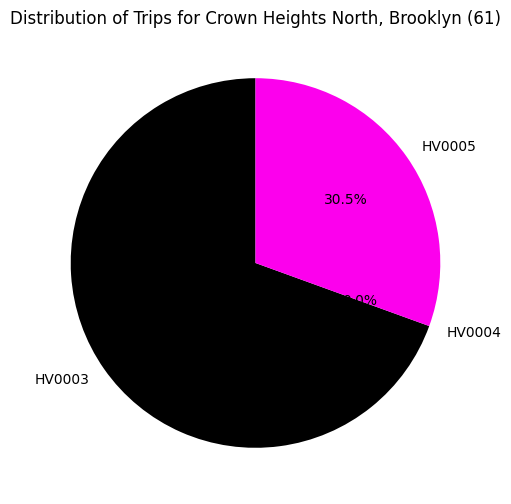

In [ ]:
# Filter data for PULocationID == 61
pulocation_61 = top_pulocation_ids.loc[(slice(None), 61)].reset_index()
pulocation_61.columns = ['hvfhs_license_num', 'count']

# Create proportions for the pie chart
all_license_nums = ['HV0003', 'HV0004', 'HV0005']
pulocation_61 = pulocation_61.set_index('hvfhs_license_num').reindex(all_license_nums, fill_value=0).reset_index()

proportions = pulocation_61['count'] / pulocation_61['count'].sum()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(proportions, labels=pulocation_61['hvfhs_license_num'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Trips for Crown Heights North, Brooklyn (61)')
plt.show()

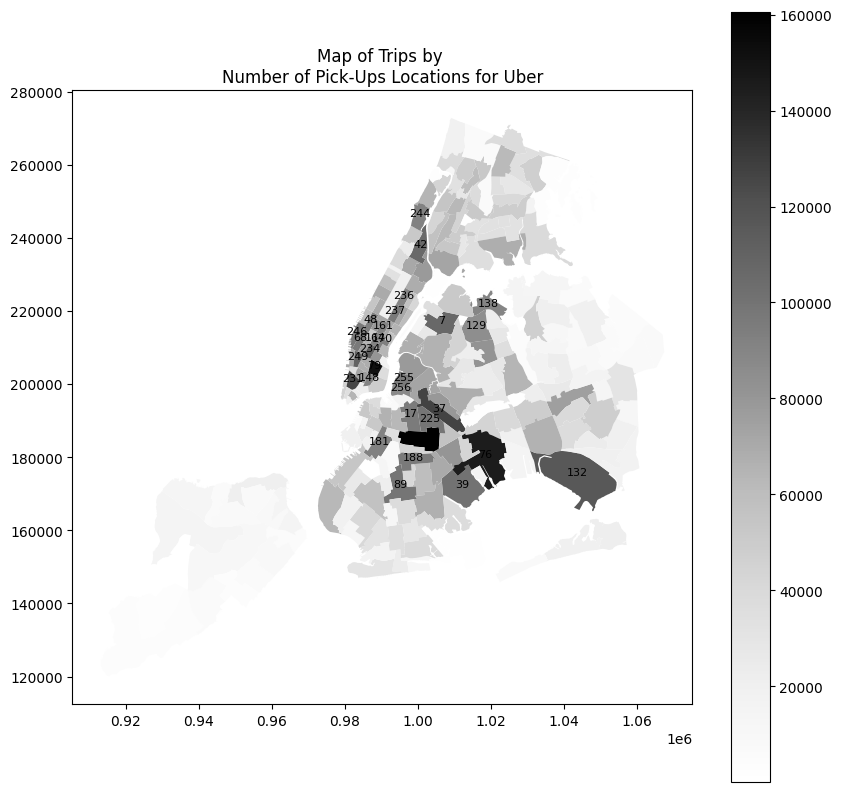

In [ ]:
# Filter gdf to include only the DOLocationIDs present in trips with 'hvfhs_license_num' == 'HV0003'
filtered_trips_hv0003 = trips[trips['hvfhs_license_num'] == 'HV0003']
filtered_gdf = gdf[gdf['LocationID'].isin(filtered_trips_hv0003['PULocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = filtered_trips_hv0003['PULocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='Greys', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Pick-Ups Locations for Uber")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(30)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

Obtener un mapa de densidad -> No es lo mismo para un LocationID de área grande, que para área pequeña.

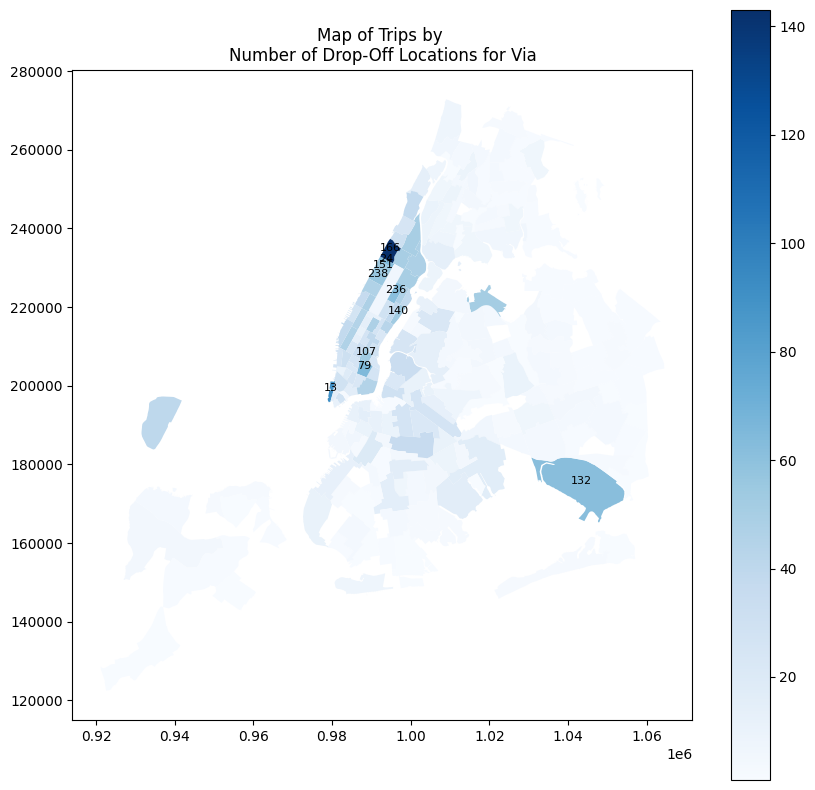

In [ ]:
# Filter gdf to include only the DOLocationIDs present in trips with 'hvfhs_license_num' == 'HV0003'
filtered_trips_hv0004 = trips[trips['hvfhs_license_num'] == 'HV0004']
filtered_gdf = gdf[gdf['LocationID'].isin(filtered_trips_hv0004['DOLocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = filtered_trips_hv0004['DOLocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='Blues', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Drop-Off Locations for Via")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(10)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

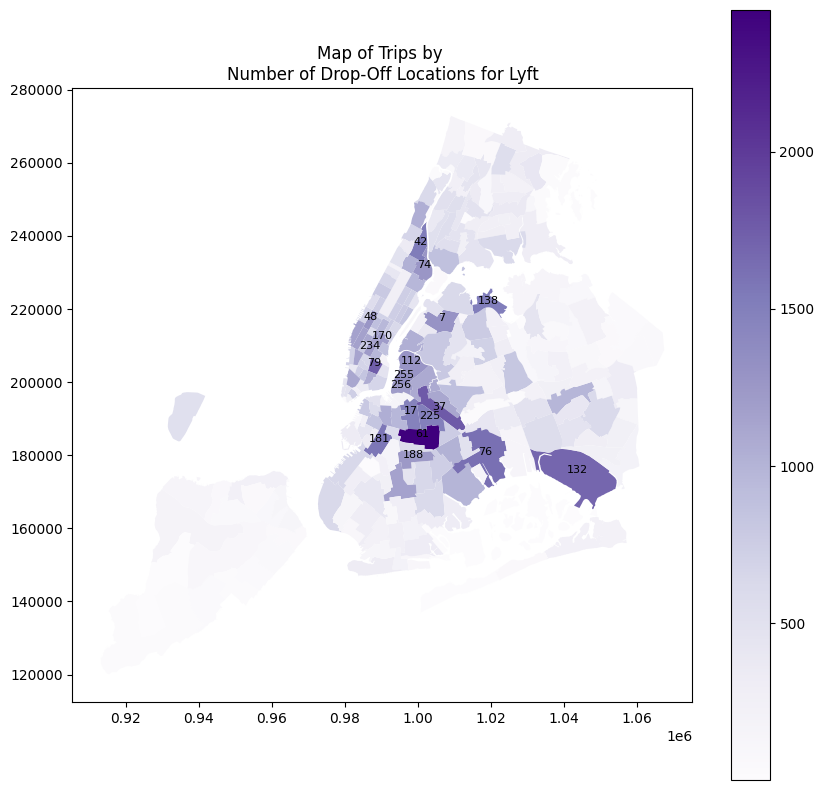

In [ ]:
# Filter gdf to include only the DOLocationIDs present in trips with 'hvfhs_license_num' == 'HV0003'
filtered_trips_hv0005 = trips[trips['hvfhs_license_num'] == 'HV0005']
filtered_gdf = gdf[gdf['LocationID'].isin(filtered_trips_hv0005['DOLocationID'].value_counts().index)]

# Merge the value counts with the filtered GeoDataFrame
value_counts = filtered_trips_hv0005['DOLocationID'].value_counts()
filtered_gdf = filtered_gdf.merge(value_counts.rename('count'), left_on='LocationID', right_index=True)

# Plot the map
ax = filtered_gdf.plot(column='count', legend=True, cmap='Purples', figsize=(10, 10))
plt.title("Map of Trips by \nNumber of Drop-Off Locations for Lyft")

# Add labels for the top 10 LocationIDs
top_10 = value_counts.head(20)
for loc_id in top_10.index:
    row = filtered_gdf[filtered_gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

In [26]:
# Group by 'hvfhs_license_num' and 'PULocationID' to calculate the total counts
pulocation_counts = trips.groupby(['hvfhs_license_num', 'PULocationID']).size().unstack(fill_value=0)

# Determine the license with the highest count for each 'PULocationID'
dominant_license = pulocation_counts.idxmax()

# Map the dominant license to colors
license_color_map = {'HV0003': 'black', 'HV0004': 'blue', 'HV0005': '#fc00ed'}
location_colors = dominant_license.map(license_color_map)

# Merge the colors into the GeoDataFrame
gdf['color'] = gdf['LocationID'].map(location_colors)


<ipython-input-30-067a578c4104>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




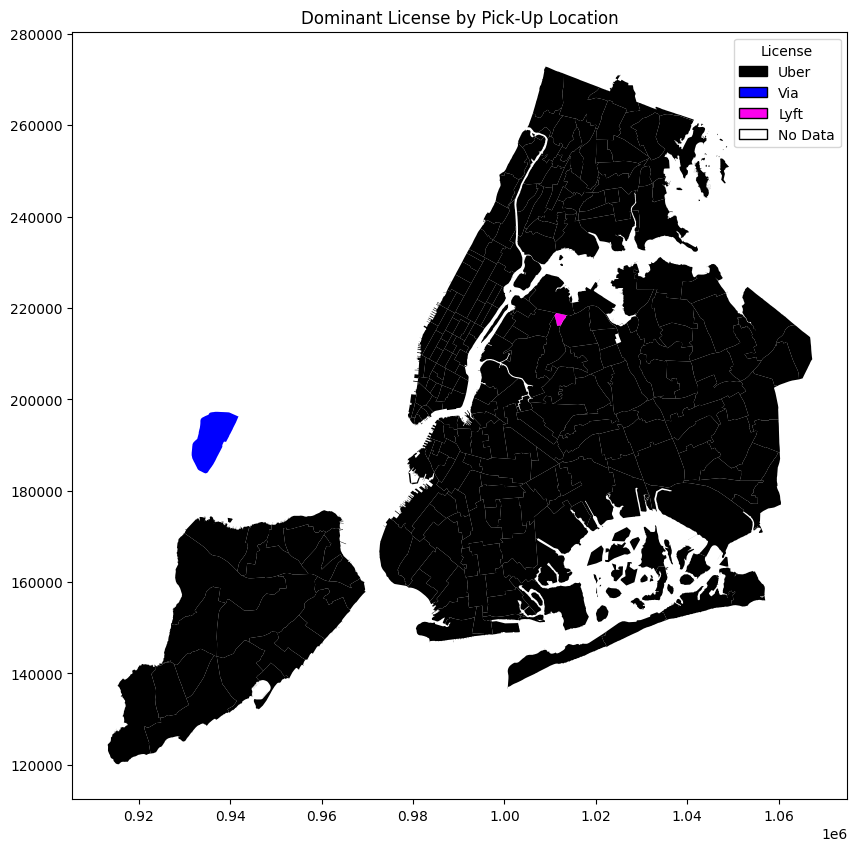

In [ ]:
from matplotlib.patches import Patch

# Fill missing colors with white
gdf['color'].fillna('white', inplace=True)

# Plot the map with the assigned colors
ax = gdf.plot(color=gdf['color'], figsize=(10, 10))
plt.title("Dominant License by Pick-Up Location")

# Create a custom legend
legend_elements = [
    Patch(facecolor='black', edgecolor='black', label='Uber'),
    Patch(facecolor='blue', edgecolor='black', label='Via'),
    Patch(facecolor='#fc00ed', edgecolor='black', label='Lyft'),
    Patch(facecolor='white', edgecolor='black', label='No Data')
]
plt.legend(handles=legend_elements, title="License", loc='upper right')

plt.show()

In [ ]:
pulocation_counts

PULocationID       1    2    3     4    5    6     7    8    9     10   ...  \
hvfhs_license_num                                                       ...   
HV0003               0    0  904  1222   87  220  3644   17  292  1237  ...   
HV0004              10    0    2    29    0    1    25    0    0     2  ...   
HV0005               0    1  256   515   31   59  1504    9  104   556  ...   

PULocationID        255   256  257   258   259   260   261   262   263  265  
hvfhs_license_num                                                            
HV0003             3171  2989  441  1356  1270  1490  1140  1403  1883   28  
HV0004               32    24    2     2     1     1    16    40    50    3  
HV0005             1355  1250  259   377   420   510   438   578   779   20  

[3 rows x 260 columns]

In [27]:
difference_license = pulocation_counts.loc['HV0003'] - pulocation_counts.loc['HV0005']

In [28]:
from matplotlib.colors import LinearSegmentedColormap

# Definimos los colores: rosa para negativos, blanco en cero, negro para positivos
colors_rosa_negro = ['#fc00ed', '#ffffff', '#000000']  # rosa fuerte → blanco → negro
rosa_blanco_negro = LinearSegmentedColormap.from_list(
    'rosa_blanco_negro',
    colors_rosa_negro,
    N=256  # resolución del gradiente
)

max_abs_value = max(abs(filtered_gdf['count'].min()), filtered_gdf['count'].max())


NameError: name 'filtered_gdf' is not defined

In [29]:
total_counts = pulocation_counts.sum()
difference_license_pct = ((pulocation_counts.loc['HV0003'] - pulocation_counts.loc['HV0005']) / total_counts) * 100
difference_license_pct

PULocationID
1      -0.877193
2      34.482759
3      58.780578
4      37.962911
5      56.078833
         ...    
260    50.374748
261    47.411770
262    42.350618
263    41.103196
265     6.624319
Length: 261, dtype: float64

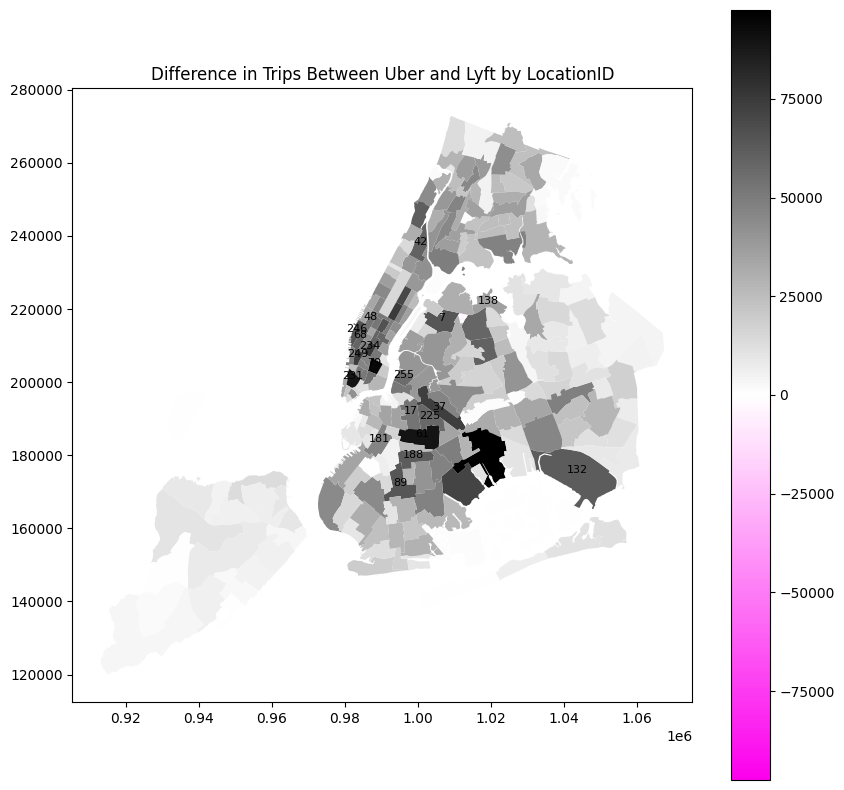

In [ ]:
# Merge the difference_license data with the GeoDataFrame
gdf['difference'] = gdf['LocationID'].map(difference_license)
top_20_locations = total_counts.nlargest(20)
max_abs_value = max(abs(gdf['difference'].min()), gdf['difference'].max())

# Usar el colormap personalizado
ax = gdf.plot(
    column='difference',
    cmap=rosa_blanco_negro,
    legend=True,
    figsize=(10, 10),
    vmin=-max_abs_value,
    vmax=max_abs_value
)

plt.title("Difference in Trips Between Uber and Lyft by LocationID")

# Add labels for the top 20 LocationIDs
for loc_id in top_20_locations.index:
    row = gdf[gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

Revisar los LocationID en los que ganaba Lyft, ¿cuánta es la diferencia?

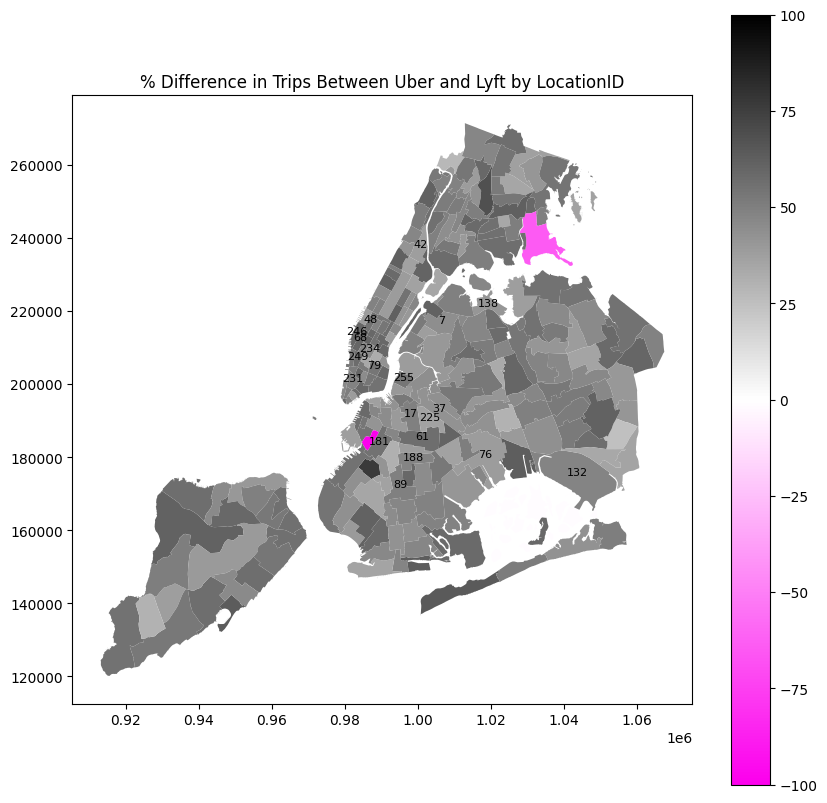

In [ ]:
# Calculate the percentage difference between Uber and Lyft trips
gdf['difference_license_pct'] = (pulocation_counts.loc['HV0003'] - pulocation_counts.loc['HV0005']) / total_counts * 100

# Filter the top 20 LocationIDs based on total_counts
top_20_locations = total_counts.nlargest(20)
max_abs_value = max(abs(gdf['difference_license_pct'].min()), gdf['difference_license_pct'].max())

# Plot the map
ax = gdf.plot(
    column='difference_license_pct',
    cmap=rosa_blanco_negro,
    legend=True,
    figsize=(10, 10),
    vmin=-max_abs_value,
    vmax=max_abs_value
)

plt.title("% Difference in Trips Between Uber and Lyft by LocationID")

# Add labels for the top 20 LocationIDs
for loc_id in top_20_locations.index:
    row = gdf[gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

trip_miles, trip_time

In [ ]:
trips_copy.loc[:,['trip_miles','hvfhs_license_num']].groupby('hvfhs_license_num').describe()

trip_miles                                               \
                        count      mean       std  min    25%    50%   75%   
hvfhs_license_num                                                            
HV0003             10808415.0  4.764084  5.384616  0.0  1.640  2.970  5.81   
HV0004                96322.0  5.540032  5.426454  0.0  1.760  3.760  7.59   
HV0005              3814434.0  5.051301  5.786380  0.0  1.676  3.125  6.32   

                           
                      max  
hvfhs_license_num          
HV0003             412.13  
HV0004             106.19  
HV0005             355.37

In [ ]:
trips_copy.loc[:,['trip_time','hvfhs_license_num']].groupby('hvfhs_license_num').describe()

trip_time                                               \
                        count         mean         std  min    25%     50%   
hvfhs_license_num                                                            
HV0003             10808415.0  1081.766282  765.419783  1.0  567.0   885.0   
HV0004                96322.0  1296.092565  867.479835  0.0  701.0  1102.0   
HV0005              3814434.0  1122.819995  782.805299  1.0  594.0   924.0   

                                    
                      75%      max  
hvfhs_license_num                   
HV0003             1371.0  42153.0  
HV0004             1659.0  49052.0  
HV0005             1426.0  35485.0

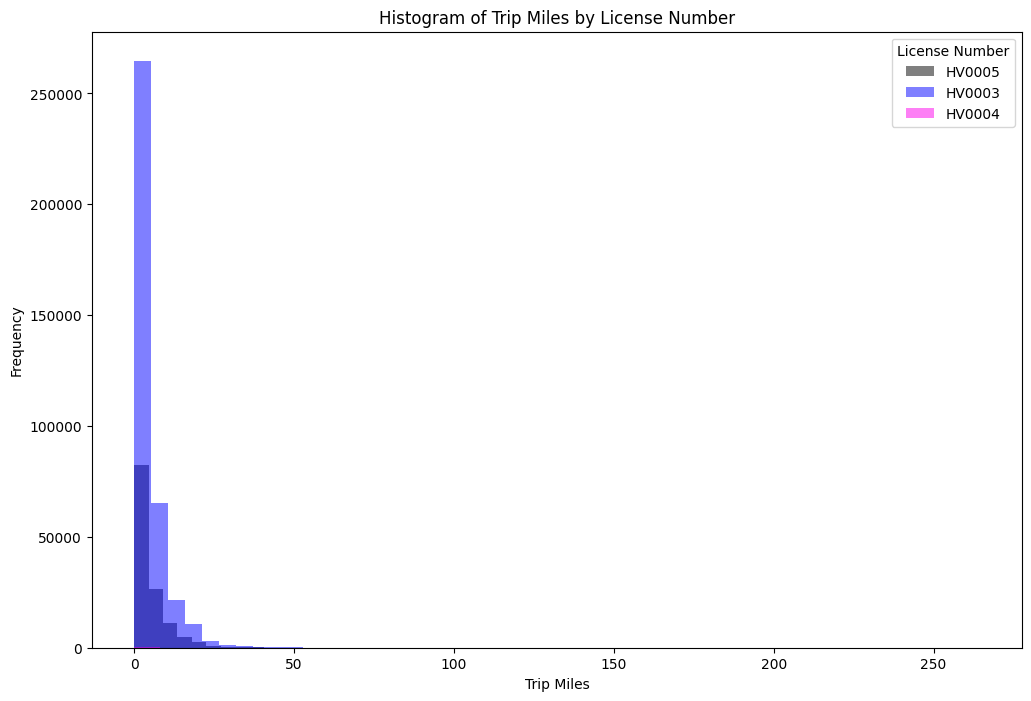

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Create histograms for each hvfhs_license_num
unique_license_nums = trips_copy['hvfhs_license_num'].unique()

# Set up the figure
plt.figure(figsize=(12, 8))

# Loop through each unique license number and plot a histogram
for license_num, color in zip(unique_license_nums, colors):
    subset = trips_copy[trips_copy['hvfhs_license_num'] == license_num]
    plt.hist(subset['trip_miles'], bins=50, alpha=0.5, label=license_num, color=color)

# Add labels, title, and legend
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Miles by License Number')
plt.legend(title='License Number')
plt.show()

In [ ]:
trips_copy.loc[:,['driver_pay','hvfhs_license_num']].groupby('hvfhs_license_num').describe()

driver_pay                                            \
                        count       mean        std    min   25%    50%   
hvfhs_license_num                                                         
HV0003             10808415.0  18.596103  13.916387 -82.98  9.63  14.97   
HV0004                96322.0   9.786182  12.875619   0.00  0.00   2.90   
HV0005              3814434.0  17.314321  13.709437   0.00  8.27  13.49   

                                   
                     75%      max  
hvfhs_license_num                  
HV0003             23.15  1133.49  
HV0004             17.40   121.38  
HV0005             21.92   595.12

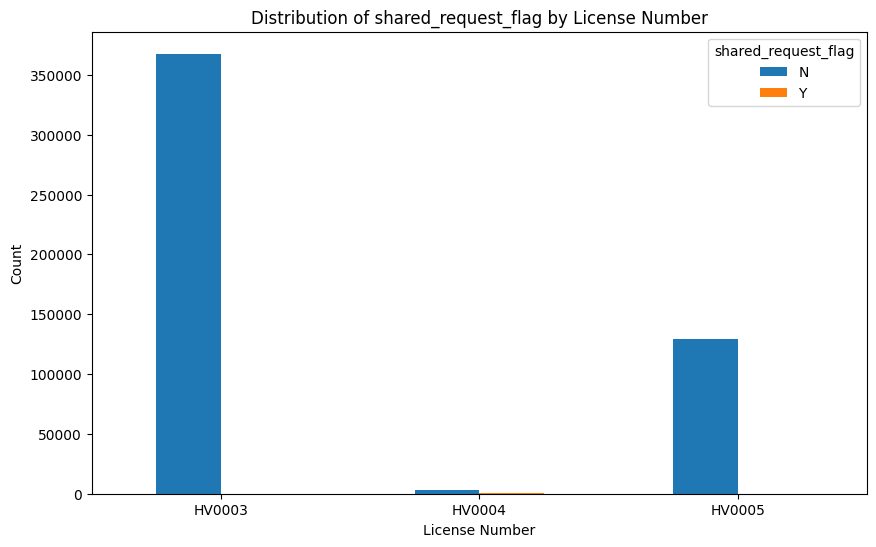

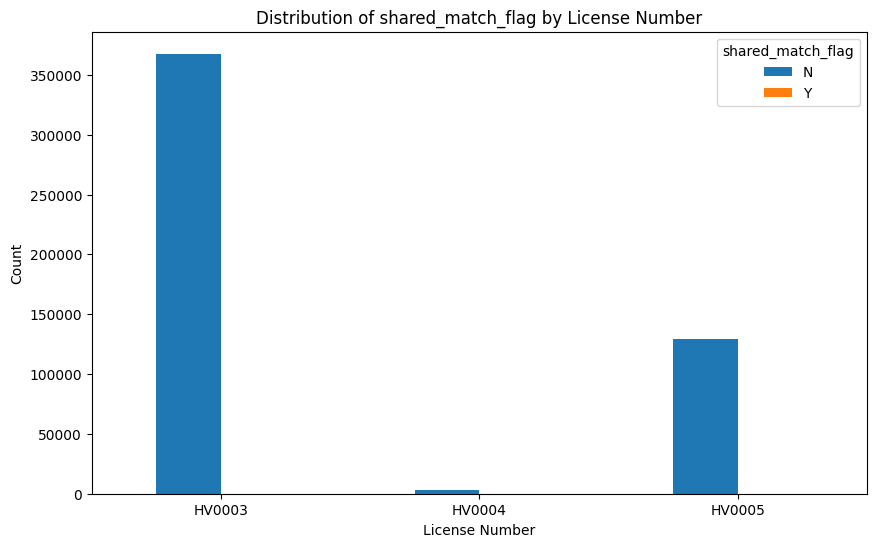

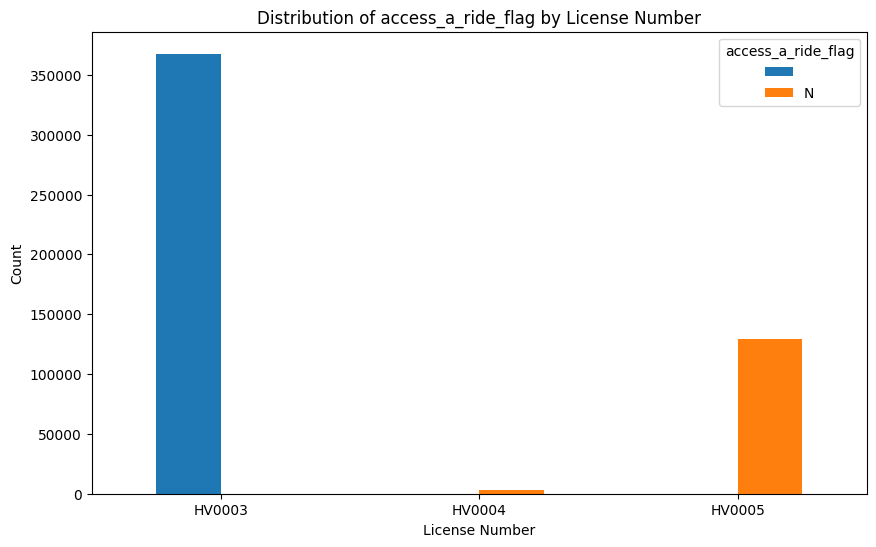

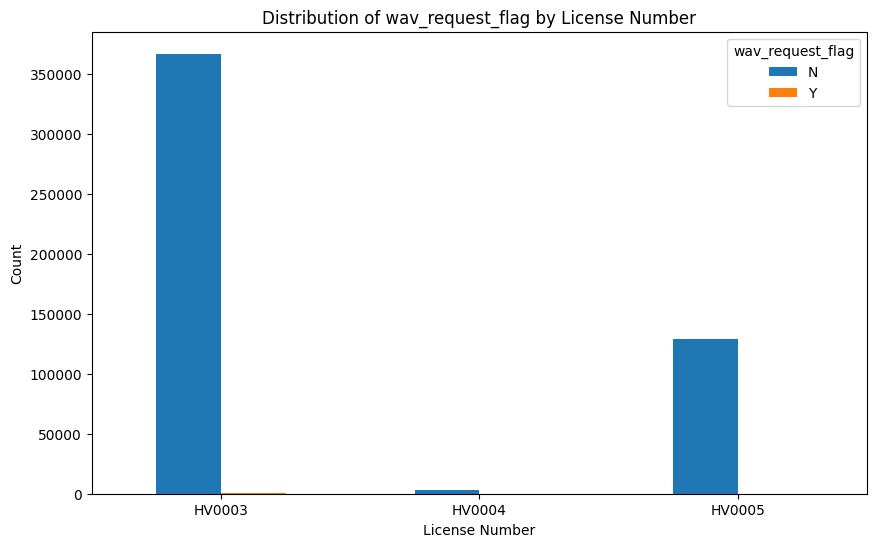

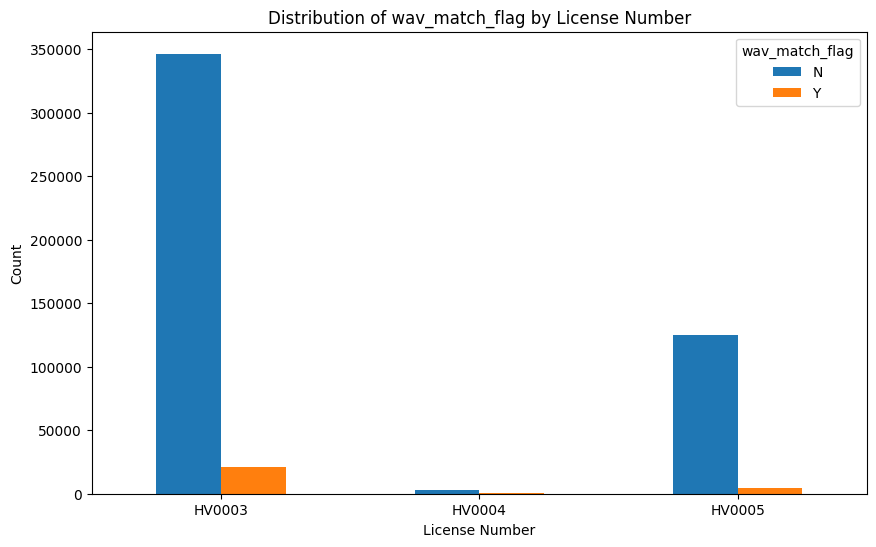

In [ ]:
import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = ['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']

# Loop through each column and generate a bar plot
for column in columns_to_plot:
    # Group by 'hvfhs_license_num' and the column, then count occurrences
    grouped_data = trips_copy.groupby(['hvfhs_license_num', column]).size().unstack(fill_value=0)

    # Plot the data
    grouped_data.plot(kind='bar', figsize=(10, 6), stacked=False)

    # Add labels and title
    plt.xlabel('License Number')
    plt.ylabel('Count')
    plt.title(f'Distribution of {column} by License Number')
    plt.xticks(rotation=0)

    # Show the plot
    plt.show()

In [ ]:
filtered_trips.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'request_hour', 'same_location',
       'PUborough', 'DOborough', 'pickup_hour', 'dropoff_hour'],
      dtype='object')

/tmp/ipykernel_645118/2951673669.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_645118/2951673669.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


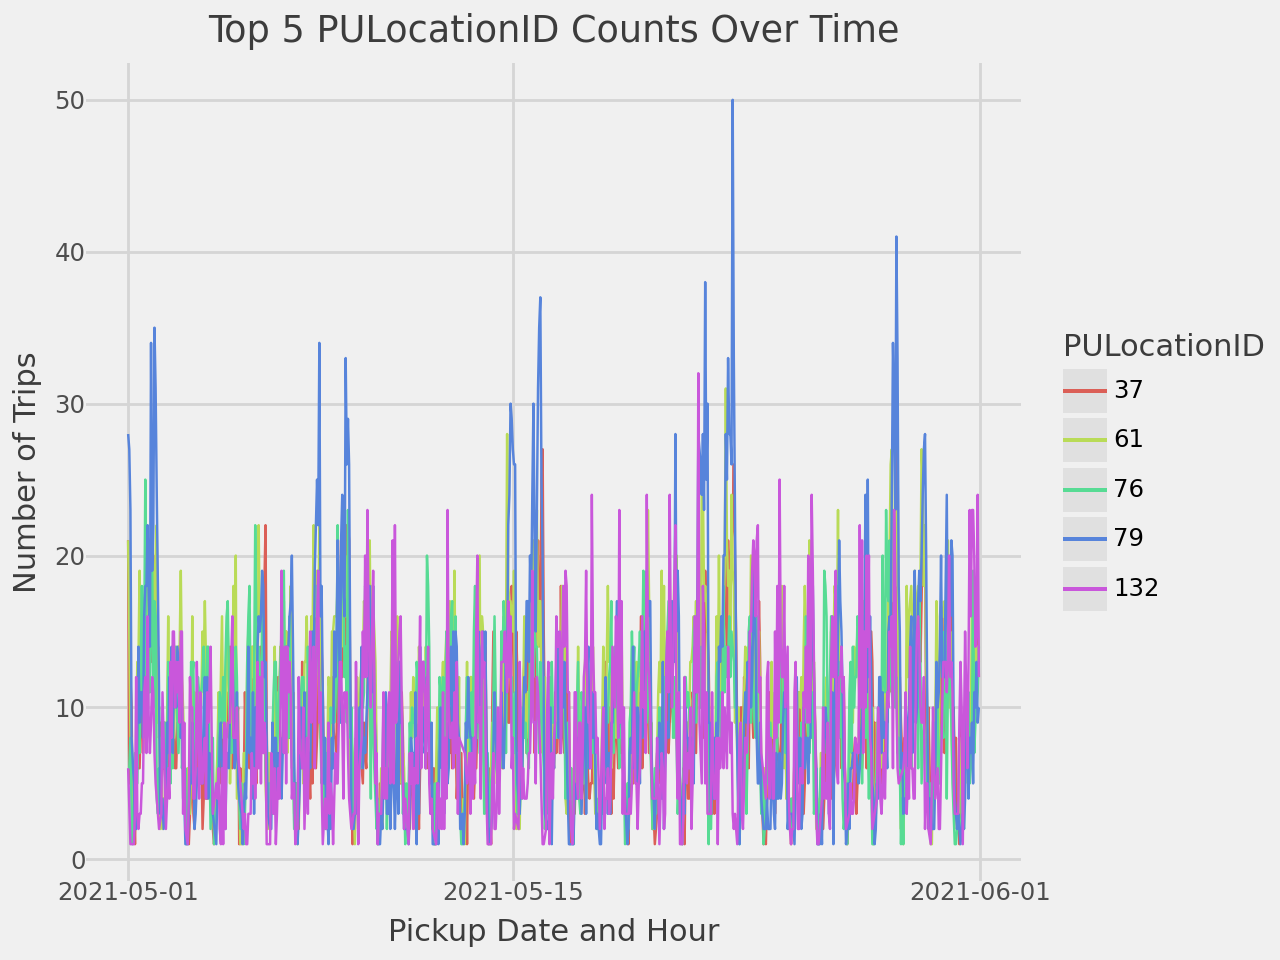

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal
import pandas as pd

# Filter trips_copy for the top 5 PULocationIDs
top_5_pulocation_ids = trips_copy['PULocationID'].value_counts().head(5).index
filtered_trips = trips_copy[trips_copy['PULocationID'].isin(top_5_pulocation_ids)]

# Create a new column for pickup_date by extracting the date from pickup_datetime
filtered_trips['pickup_date'] = pd.to_datetime(filtered_trips['pickup_datetime']).dt.date

# Create a new column for concatenated pickup_date and pickup_hour
filtered_trips['pickup_datetime_combined'] = pd.to_datetime(
    filtered_trips['pickup_date'].astype(str) + ' ' + filtered_trips['pickup_hour'].astype(str) + ':00:00'
)

# Group by PULocationID and pickup_datetime_combined, and count the number of trips
grouped_data = (
    filtered_trips.groupby(['PULocationID', 'pickup_datetime_combined'])
    .size()
    .reset_index(name='count')
)

# Create the geom_line plot
plot = (
    ggplot(grouped_data, aes(x='pickup_datetime_combined', y='count', color='factor(PULocationID)')) +
    geom_line() +
    labs(
        title='Top 5 PULocationID Counts Over Time',
        x='Pickup Date and Hour',
        y='Number of Trips',
        color='PULocationID'
    ) +
    theme_538()
)

plot

/tmp/ipykernel_645118/3680139586.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_645118/3680139586.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


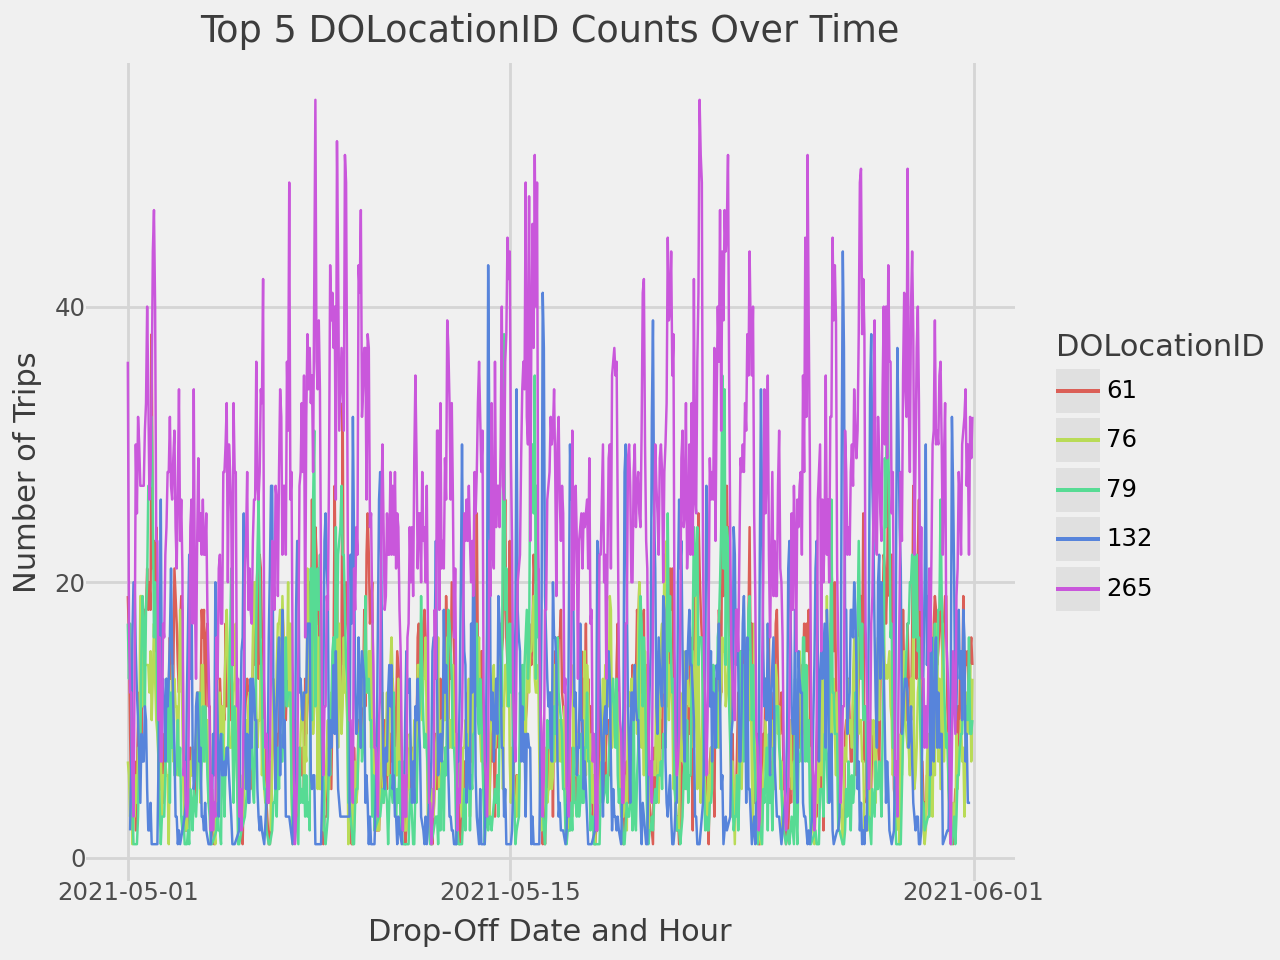

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal
import pandas as pd

# Filter trips_copy for the top 5 PULocationIDs
top_5_pulocation_ids = trips_copy['DOLocationID'].value_counts().head(5).index
filtered_trips = trips_copy[trips_copy['DOLocationID'].isin(top_5_pulocation_ids)]

# Create a new column for pickup_date by extracting the date from pickup_datetime
filtered_trips['pickup_date'] = pd.to_datetime(filtered_trips['pickup_datetime']).dt.date

# Create a new column for concatenated pickup_date and pickup_hour
filtered_trips['pickup_datetime_combined'] = pd.to_datetime(
    filtered_trips['pickup_date'].astype(str) + ' ' + filtered_trips['pickup_hour'].astype(str) + ':00:00'
)

# Group by DOLocationID and pickup_datetime_combined, and count the number of trips
grouped_data = (
    filtered_trips.groupby(['DOLocationID', 'pickup_datetime_combined'])
    .size()
    .reset_index(name='count')
)

# Create the geom_line plot
plot = (
    ggplot(grouped_data, aes(x='pickup_datetime_combined', y='count', color='factor(DOLocationID)')) +
    geom_line() +
    labs(
        title='Top 5 DOLocationID Counts Over Time',
        x='Drop-Off Date and Hour',
        y='Number of Trips',
        color='DOLocationID'
    ) +
    theme_538()
)

plot

In [ ]:
# import pandas as pd

# import plotly.graph_objects as go

# # Filter the top 20 DOLocationID based on their counts
# top_20_dolocation_ids = trips['DOLocationID'].value_counts().head(20).index

# # Filter trips for only the top 20 DOLocationID
# filtered_trips = trips[trips['DOLocationID'].isin(top_20_dolocation_ids)]

# # Group by PULocationID and DOLocationID and count the number of trips
# sankey_data = (
#     filtered_trips.groupby(['PULocationID', 'DOLocationID'])
#     .size()
#     .reset_index(name='count')
# )

# # Create lists of unique PULocationID and DOLocationID
# pulocation_ids = sankey_data['PULocationID'].unique()
# dolocation_ids = sankey_data['DOLocationID'].unique()

# # Create a mapping of location IDs to indices
# location_ids = list(pulocation_ids) + list(dolocation_ids)
# location_map = {loc_id: idx for idx, loc_id in enumerate(location_ids)}

# # Map PULocationID and DOLocationID to their indices
# sankey_data['source'] = sankey_data['PULocationID'].map(location_map)
# sankey_data['target'] = sankey_data['DOLocationID'].map(location_map)

# # Create the Sankey diagram
# fig = go.Figure(data=[go.Sankey(
#     node=dict(
#         pad=15,
#         thickness=20,
#         line=dict(color="black", width=0.5),
#         label=[str(loc_id) for loc_id in location_ids]
#     ),
#     link=dict(
#         source=sankey_data['source'],
#         target=sankey_data['target'],
#         value=sankey_data['count']
#     )
# )])

# fig.update_layout(title_text="Sankey Diagram for Top 20 DOLocationID", font_size=10)
# fig.show()

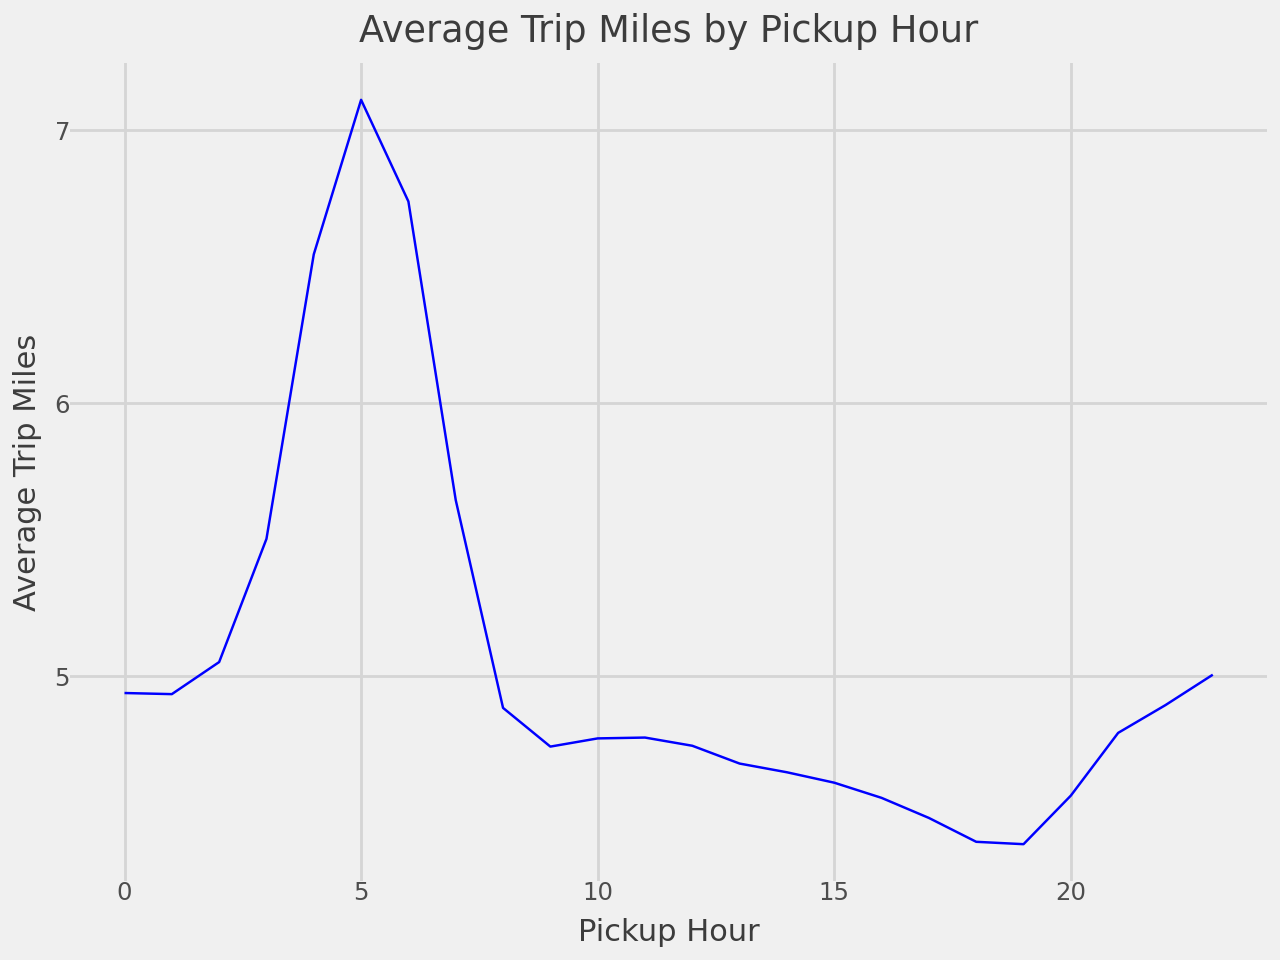

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

# Group by pickup_hour and calculate the average trip_miles
grouped_data = trips_copy.groupby('pickup_hour')['trip_miles'].mean().reset_index()

# Create the geom_line plot
plot = (
    ggplot(grouped_data, aes(x='pickup_hour', y='trip_miles')) +
    geom_line(color='blue') +
    labs(
        title='Average Trip Miles by Pickup Hour',
        x='Pickup Hour',
        y='Average Trip Miles'
    ) +
    theme_538()
)

plot

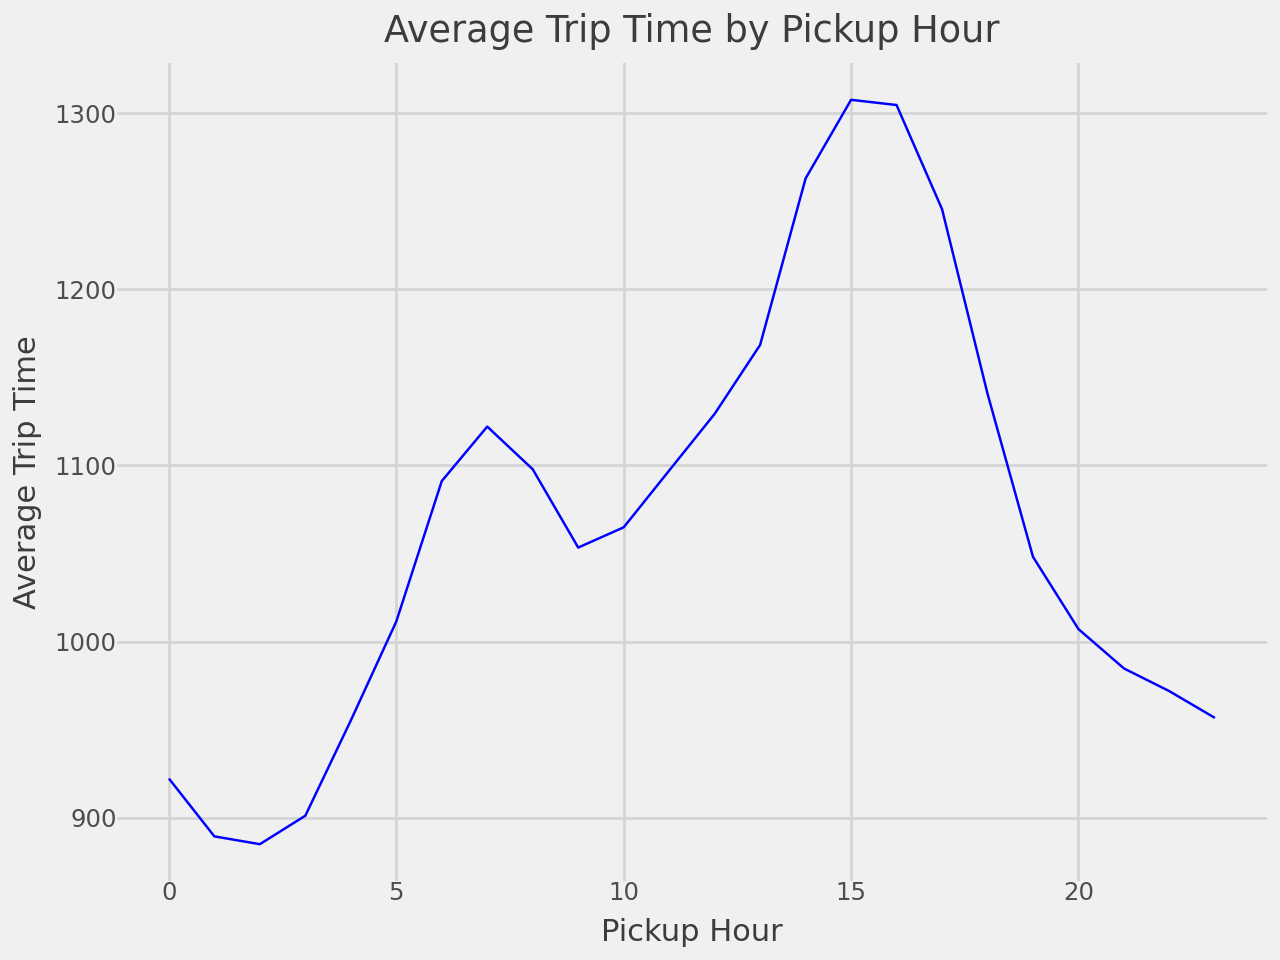

In [ ]:
# Group by pickup_hour and calculate the average trip_miles
grouped_data = trips_copy.groupby('pickup_hour')['trip_time'].mean().reset_index()

# Create the geom_line plot
plot = (
    ggplot(grouped_data, aes(x='pickup_hour', y='trip_time')) +
    geom_line(color='blue') +
    labs(
        title='Average Trip Time by Pickup Hour',
        x='Pickup Hour',
        y='Average Trip Time'
    ) +
    theme_538()
)

plot

scatter plots para taxes, tips and tolls por trip_miles and trip_time

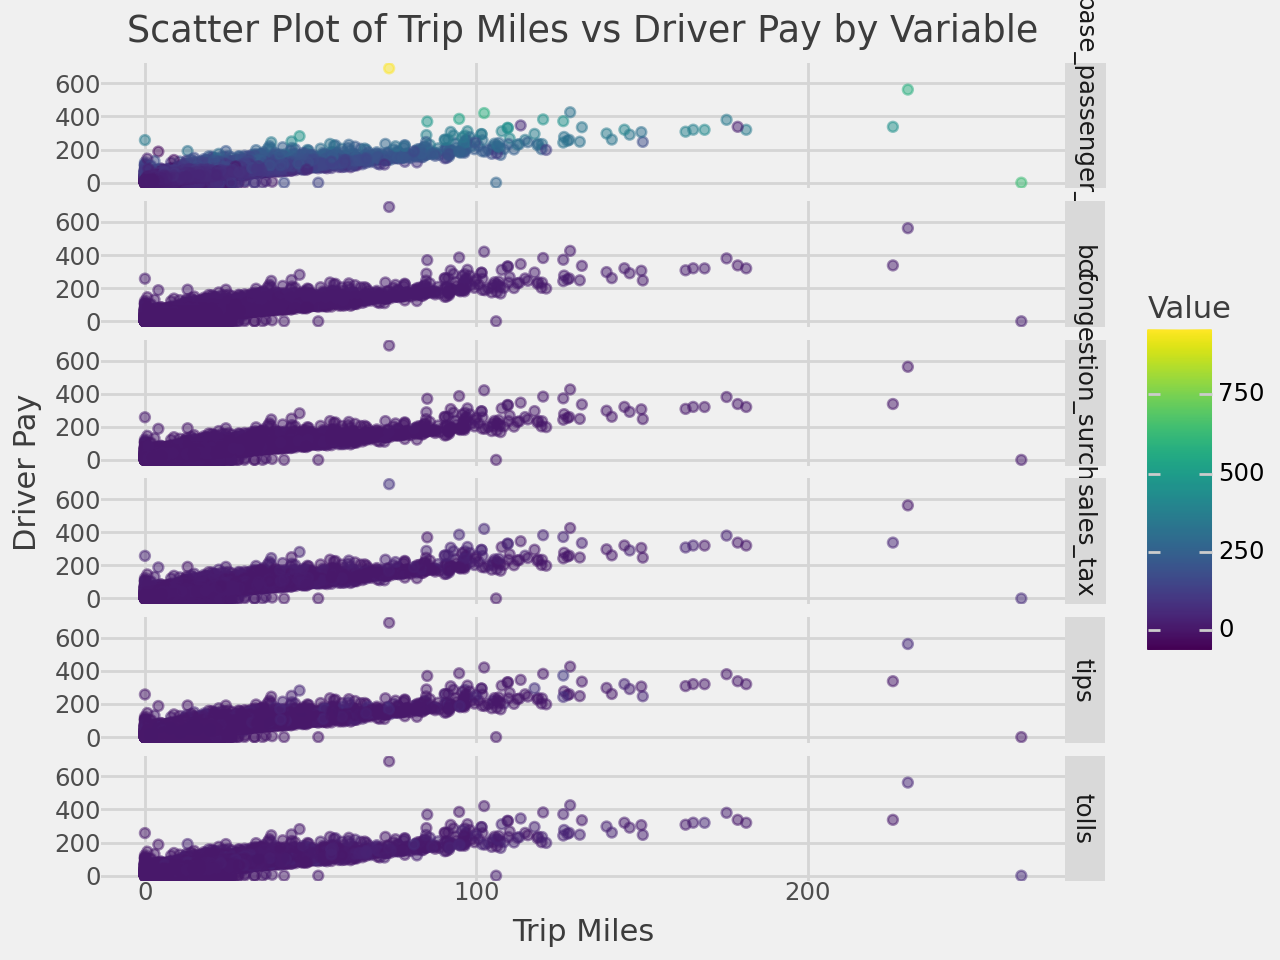

In [ ]:
from plotnine import ggplot, aes, geom_point, facet_grid, labs, theme_minimal

# Reshape the data into long format
variables = ['tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'tips', 'base_passenger_fare']
long_data = trips_copy.melt(id_vars=['trip_miles', 'driver_pay'], value_vars=variables,
                            var_name='Variable', value_name='Value')

# Create the scatter plot with facet_grid
plot = (
    ggplot(long_data, aes(x='trip_miles', y='driver_pay', color='Value')) +
    geom_point(alpha=0.5) +
    facet_grid('Variable ~ .') +
    labs(
        title='Scatter Plot of Trip Miles vs Driver Pay by Variable',
        x='Trip Miles',
        y='Driver Pay',
        color='Value'
    ) +
    theme_538()
)

plot

In [ ]:
# Reshape the data into long format
variables = ['tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'tips', 'base_passenger_fare']
long_data = trips_copy.melt(id_vars=['trip_time', 'driver_pay'], value_vars=variables,
                            var_name='Variable', value_name='Value')

# Create the scatter plot with facet_grid
plot = (
    ggplot(long_data, aes(x='trip_time', y='driver_pay', color='Value')) +
    geom_point(alpha=0.5) +
    facet_grid('Variable ~ .') +
    labs(
        title='Scatter Plot of Trip Time vs Driver Pay by Variable',
        x='Trip Time',
        y='Driver Pay',
        color='Value'
    ) +
    theme_538()
)

plot

- Para los scatters, relación entre las variables y el driver pay (que % representa)
- Revisar definición 'driver_pay' -> Comparar barras entre driver_pay y resto de pagos

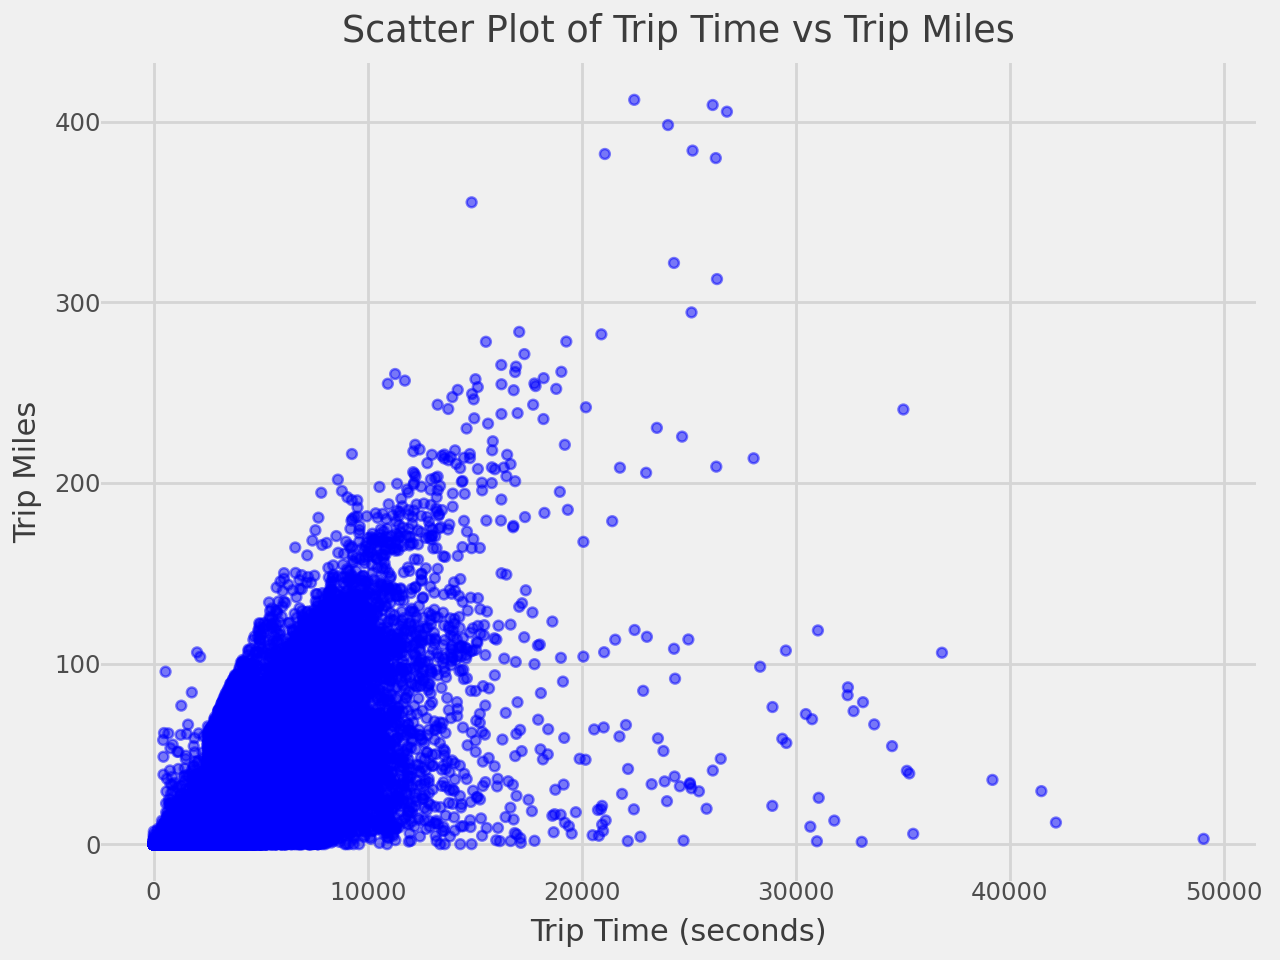

In [ ]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

# Create the scatter plot
plot = (
    ggplot(trips_copy, aes(x='trip_time', y='trip_miles')) +
    geom_point(alpha=0.5, color='blue') +
    labs(
        title='Scatter Plot of Trip Time vs Trip Miles',
        x='Trip Time (seconds)',
        y='Trip Miles'
    ) +
    theme_538()
)

plot

<Figure size 1200x800 with 0 Axes>

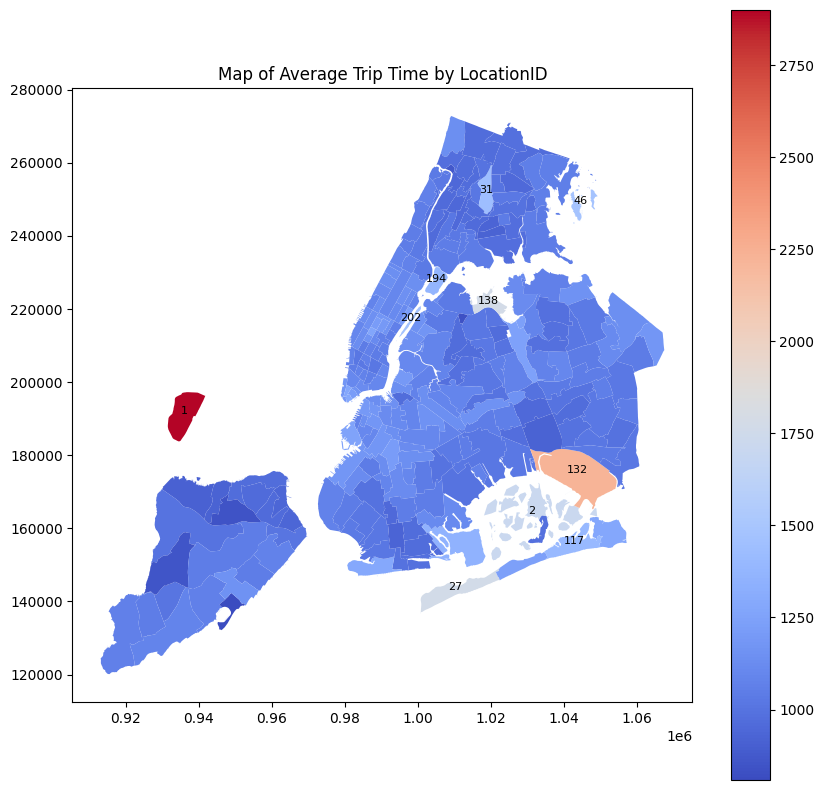

In [ ]:
# Calculate the average trip_time for each PULocationID
avg_trip_time = trips_copy.groupby('PULocationID')['trip_time'].mean()

# Merge the average trip_time with the GeoDataFrame
gdf = gdf.merge(avg_trip_time.rename('avg_trip_time'), left_on='LocationID', right_index=True, how='left')

# Plot the map
plt.figure(figsize=(12, 8))
ax = gdf.plot(column='avg_trip_time', legend=True, cmap='coolwarm', figsize=(10, 10))
plt.title("Map of Average Trip Time by LocationID")

# Add labels for the top 10 LocationIDs with the highest average trip_time
top_10_avg_trip_time = avg_trip_time.nlargest(10)
for loc_id in top_10_avg_trip_time.index:
    row = gdf[gdf['LocationID'] == loc_id]
    if not row.empty:
        x, y = row.geometry.centroid.x.values[0], row.geometry.centroid.y.values[0]
        plt.text(x, y, str(loc_id), fontsize=8, color='black', ha='center')

plt.show()

Para trip_miles o trip_time, generar un mapa como diagrama de divergencias (salida: PULocationID, llegada DOLocationID)

Otros gráficos:
- hora viaje en misma localización
- Agrupar por boroughs
- Desagregar por tipo de VTC (como tercera variable)

### Matriz de correlaciones

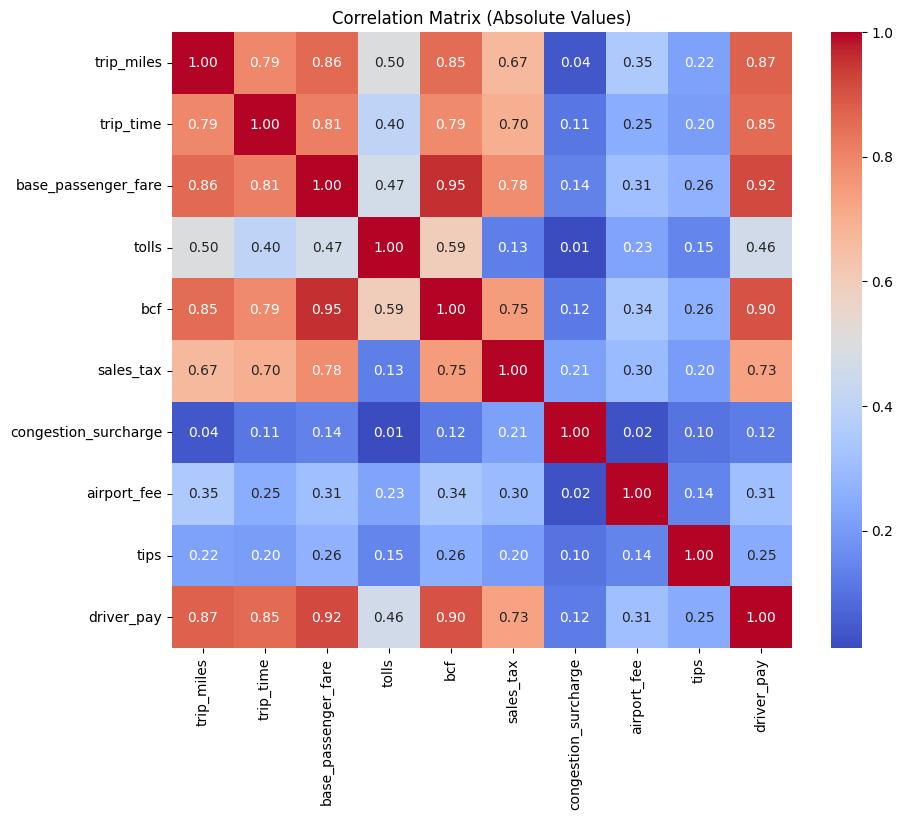

In [30]:
import seaborn as sns

import matplotlib.pyplot as plt

# Select numeric columns excluding PULocationID and DOLocationID
numeric_columns = trips.select_dtypes(include=['number']).drop(columns=['PULocationID', 'DOLocationID','request_hour'])

# Compute the correlation matrix and take absolute values
correlation_matrix = numeric_columns.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix (Absolute Values)')
plt.show()

## Data Pre-processing


In [ ]:
trips_preprocessing = trips.copy()

### Data Preparation
- Data Cleaning
- Data Transformation
- Data Integration
- Data Normalization
- Missing Data Imputation
- Noise Identification (Outliers)

¿Cómo tratar datetime variables?

**Para variables datetime**
- Comprobar que trip_time es igual a la diferencia de timestamp entre pickup y dropoff
- Extraer hora y día de la semana. Identificar si es día laborable o fin de semana.
- Extra: extraer mes: identificar periodo (Verano, Navidad...)

In [ ]:
trips_preprocessing[['request_datetime','on_scene_datetime','pickup_datetime']].head()

request_datetime   on_scene_datetime     pickup_datetime
0 2021-05-01 00:05:23 2021-05-01 00:06:08 2021-05-01 00:07:26
1 2021-05-01 00:13:48 2021-05-01 00:17:28 2021-05-01 00:17:47
2 2021-05-01 00:43:08 2021-05-01 00:47:11 2021-05-01 00:47:11
3 2021-05-01 00:56:01 2021-05-01 00:58:04 2021-05-01 00:59:29
4 2021-05-01 00:10:52 2021-05-01 00:15:57 2021-05-01 00:16:21

In [ ]:
type(trips_preprocessing['on_scene_datetime'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
trips_preprocessing['pickup_datetime'] = pd.to_datetime(trips_preprocessing['pickup_datetime'])
trips_preprocessing['request_datetime'] = pd.to_datetime(trips_preprocessing['request_datetime'])

In [ ]:
# Calculate the mean datetime between 'request_datetime' and 'pickup_datetime'
mean_datetime = trips_preprocessing[['request_datetime', 'pickup_datetime']].mean(axis=1)

# Impute NaN values in 'on_scene_datetime' with the calculated mean datetime
trips_preprocessing['on_scene_datetime'] = trips_preprocessing['on_scene_datetime'].fillna(mean_datetime)

# Ensure the column is in datetime format
trips_preprocessing['on_scene_datetime'] = pd.to_datetime(trips_preprocessing['on_scene_datetime'])

In [ ]:
# List of datetime columns to process
# Extract 'day' and 'hour' for each datetime column
for col in datetime_columns:
    trips_preprocessing[f'{col}_day'] = pd.to_datetime(trips_preprocessing[col]).dt.day
    trips_preprocessing[f'{col}_hour'] = pd.to_datetime(trips_preprocessing[col]).dt.hour

# Display the updated DataFrame
trips_preprocessing.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B02764               B02764   
1            HV0003               B02764               B02764   
2            HV0003               B02764               B02764   
3            HV0003               B02764               B02764   
4            HV0003               B02764               B02764   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2021-05-01 00:05:23 2021-05-01 00:06:08 2021-05-01 00:07:26   
1 2021-05-01 00:13:48 2021-05-01 00:17:28 2021-05-01 00:17:47   
2 2021-05-01 00:43:08 2021-05-01 00:47:11 2021-05-01 00:47:11   
3 2021-05-01 00:56:01 2021-05-01 00:58:04 2021-05-01 00:59:29   
4 2021-05-01 00:10:52 2021-05-01 00:15:57 2021-05-01 00:16:21   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  PUborough  \
0 2021-05-01 00:14:44           246           234        1.22  ...  Manhattan   
1 2021-05-01 00:31:24           113           238        4.59  ...  Manhattan   
2 2021-05-01 00:55:24           236           262        1.37  ...  Manhattan   
3 2021-05-01 01:12:06           262           143        2.99  ...  Manhattan   
4 2021-05-01 00:59:12           263           265       31.16  ...  Manhattan   

   DOborough  request_datetime_day  request_datetime_hour  \
0  Manhattan                     1                      0   
1  Manhattan                     1                      0   
2  Manhattan                     1                      0   
3  Manhattan                     1                      0   
4        NaN                     1                      0   

   on_scene_datetime_day  on_scene_datetime_hour  pickup_datetime_day  \
0                      1                       0                    1   
1                      1                       0                    1   
2                      1                       0                    1   
3                      1                       0                    1   
4                      1                       0                    1   

   pickup_datetime_hour  dropoff_datetime_day dropoff_datetime_hour  
0                     0                     1                     0  
1                     0                     1                     0  
2                     0                     1                     0  
3                     0                     1                     1  
4                     0                     1                     0  

[5 rows x 36 columns]

In [ ]:
trips_preprocessing[['request_datetime','on_scene_datetime','pickup_datetime','dropoff_datetime','trip_time']].head()

request_datetime   on_scene_datetime     pickup_datetime  \
0 2021-05-01 00:05:23 2021-05-01 00:06:08 2021-05-01 00:07:26   
1 2021-05-01 00:13:48 2021-05-01 00:17:28 2021-05-01 00:17:47   
2 2021-05-01 00:43:08 2021-05-01 00:47:11 2021-05-01 00:47:11   
3 2021-05-01 00:56:01 2021-05-01 00:58:04 2021-05-01 00:59:29   
4 2021-05-01 00:10:52 2021-05-01 00:15:57 2021-05-01 00:16:21   

     dropoff_datetime  trip_time  
0 2021-05-01 00:14:44        438  
1 2021-05-01 00:31:24        817  
2 2021-05-01 00:55:24        493  
3 2021-05-01 01:12:06        757  
4 2021-05-01 00:59:12       2571

Convertir datetime variables a tipo timestamp

In [ ]:
# Transform datetime columns to Unix timestamps
timestamp_data = trips_preprocessing[datetime_columns]

for col in timestamp_data:
    timestamp_data[col] = pd.to_datetime(timestamp_data[col]).astype(int) / 10**9  # Convert to seconds

# Display the updated DataFrame
timestamp_data.head()

<ipython-input-53-5528b33ab5b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-53-5528b33ab5b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-53-5528b33ab5b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-53-5528b33ab5b4>

request_datetime  on_scene_datetime  pickup_datetime  dropoff_datetime
0       1619827.523        1619827.568      1619827.646       1619828.084
1       1619828.028        1619828.248      1619828.267       1619829.084
2       1619829.788        1619830.031      1619830.031       1619830.524
3       1619830.561        1619830.684      1619830.769       1619831.526
4       1619827.852        1619828.157      1619828.181       1619830.752

In [ ]:
timestamp_data['timestamp_interval'] = timestamp_data['dropoff_datetime'] - timestamp_data['pickup_datetime']

<ipython-input-54-edacdc75d460>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
timestamp_data['trip_time'] = trips_preprocessing['trip_time']

<ipython-input-56-568e8234dc6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
timestamp_data['timestamp_interval'] *= 1000

<ipython-input-58-996596f89e3d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
timestamp_data['timestamp_interval'].head()

NameError: name 'timestamp_data' is not defined

In [ ]:
# Calculate the difference between 'timestamp_interval' and 'trip_time'
timestamp_data['difference'] = timestamp_data['timestamp_interval'] - timestamp_data['trip_time']
print(timestamp_data['difference'].describe())


<ipython-input-61-228dc7104813>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    1.471917e+07
mean    -1.988020e-03
std      6.625889e-01
min     -3.140000e+02
25%     -7.078052e-08
50%     -1.862645e-09
75%      6.705523e-08
max      6.000000e+01
Name: difference, dtype: float64


Extraer hora y día de la semana para datetime

Data Cleaning:
- Missing Values
- Noisy Data (Outliers)

In [ ]:
trips_na = trips_preprocessing.isna().sum()

In [ ]:
len(trips_preprocessing[['dispatching_base_num', 'originating_base_num']].value_counts())

43

In [ ]:
trips_preprocessing[['dispatching_base_num', 'originating_base_num']].loc[trips_preprocessing['dispatching_base_num'] != trips_preprocessing['originating_base_num']]

dispatching_base_num originating_base_num
0                    B02510                  NaN
1                    B02510                  NaN
3                    B02510                  NaN
5                    B02510                  NaN
18                   B02510                  NaN
...                     ...                  ...
499969               B02510                  NaN
499973               B02510                  NaN
499979               B02510                  NaN
499995               B02510                  NaN
499996               B02510                  NaN

[132371 rows x 2 columns]

In [ ]:
#Impute NaN values in originating_base_num based on dispatching_base_num
trips_preprocessing['originating_base_num'] = trips_preprocessing['originating_base_num'].fillna(trips_preprocessing['dispatching_base_num'])

In [ ]:
filtered_trips = trips_preprocessing[['dispatching_base_num', 'originating_base_num']].dropna().loc[
    trips_preprocessing['dispatching_base_num'] != trips_preprocessing['originating_base_num']
]
filtered_trips

dispatching_base_num originating_base_num
8999                 B02844               B02510
14007                B02844               B02510
14264                B02844               B02510
15208                B02844               B02510
17684                B02844               B02510
...                     ...                  ...
487273               B02844               B02510
489607               B02844               B02510
492917               B02844               B02510
494352               B02844               B02510
497210               B02844               B02510

[179 rows x 2 columns]

In [ ]:
trips_preprocessing[['dispatching_base_num', 'originating_base_num']].loc[trips_preprocessing['dispatching_base_num'] == 'B02844']

dispatching_base_num originating_base_num
8999                 B02844               B02510
14007                B02844               B02510
14264                B02844               B02510
15208                B02844               B02510
17684                B02844               B02510
...                     ...                  ...
487273               B02844               B02510
489607               B02844               B02510
492917               B02844               B02510
494352               B02844               B02510
497210               B02844               B02510

[157 rows x 2 columns]

In [ ]:
trips_preprocessing[trips_preprocessing['PUborough'].isna()]['PULocationID'].unique()

array([265,  57])

Se ha visto en qgis, que estas localizaciones quedan fuera de Nueva York. Se creará el valor 'Out Of New York'

In [ ]:
trips_preprocessing[trips_preprocessing['DOborough'].isna()]['DOLocationID'].unique()

array([265,  57, 105])

In [ ]:
# Impute NaN values in 'PUborough' and 'DOborough' with 'Out_of_City'
trips_preprocessing['PUborough'].fillna('Out_of_City', inplace=True)
trips_preprocessing['DOborough'].fillna('Out_of_City', inplace=True)

<ipython-input-54-5930702e9d8a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trips_preprocessing['PUborough'].fillna('Out_of_City', inplace=True)
<ipython-input-54-5930702e9d8a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Data Normalization:
- Modeling variables
- Min-Max Normalization
- Z-score Normalization

In [ ]:
trips_preprocessing.select_dtypes(include=['float64', 'int64']).columns

Index(['PULocationID', 'DOLocationID', 'trip_miles', 'trip_time',
       'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Columns to apply StandardScaler
standard_scaler_columns = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf',
                           'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']

# Columns to apply MinMaxScaler
minmax_scaler_columns = ['PULocationID', 'DOLocationID','request_datetime_day','request_datetime_hour','on_scene_datetime_day','on_scene_datetime_hour','dropoff_datetime_day','dropoff_datetime_hour','pickup_datetime_day','pickup_datetime_hour']

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply StandardScaler to the specified columns
trips_preprocessing[standard_scaler_columns] = standard_scaler.fit_transform(trips_preprocessing[standard_scaler_columns])

# Apply MinMaxScaler to the specified columns
trips_preprocessing[minmax_scaler_columns] = minmax_scaler.fit_transform(trips_preprocessing[minmax_scaler_columns])

# Display the updated DataFrame
trips_preprocessing.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0005               B02510               B02510   
1            HV0005               B02510               B02510   
2            HV0003               B02883               B02883   
3            HV0005               B02510               B02510   
4            HV0003               B02875               B02875   

     request_datetime       on_scene_datetime     pickup_datetime  \
0 2021-05-30 21:30:14 2021-05-30 21:32:52.500 2021-05-30 21:35:31   
1 2021-05-30 15:33:22 2021-05-30 15:39:16.500 2021-05-30 15:45:11   
2 2021-05-08 01:10:42 2021-05-08 01:14:33.000 2021-05-08 01:15:26   
3 2021-05-15 20:01:03 2021-05-15 20:02:16.000 2021-05-15 20:03:29   
4 2021-05-08 23:53:12 2021-05-08 23:54:58.000 2021-05-08 23:55:02   

      dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  \
0  2021-05-30 21:45:25      0.875000      0.401515   -0.512267  ...   
1  2021-05-30 15:52:35      0.094697      0.462121   -0.609923  ...   
2  2021-05-08 01:25:15      0.886364      0.446970   -0.513894  ...   
3  2021-05-15 20:16:28      0.428030      0.882576   -0.584605  ...   
4  2021-05-08 23:58:43      0.537879      0.185606   -0.747184  ...   

   PUborough  DOborough  request_datetime_day  request_datetime_hour  \
0  Manhattan  Manhattan              0.966667               0.913043   
1   Brooklyn   Brooklyn              0.966667               0.652174   
2      Bronx      Bronx              0.233333               0.043478   
3  Manhattan  Manhattan              0.466667               0.869565   
4  Manhattan  Manhattan              0.233333               1.000000   

   on_scene_datetime_day  on_scene_datetime_hour  pickup_datetime_day  \
0               0.966667                0.913043             0.966667   
1               0.966667                0.652174             0.966667   
2               0.233333                0.043478             0.233333   
3               0.466667                0.869565             0.466667   
4               0.233333                1.000000             0.233333   

   pickup_datetime_hour  dropoff_datetime_day dropoff_datetime_hour  
0              0.913043              0.966667              0.913043  
1              0.652174              0.966667              0.652174  
2              0.043478              0.233333              0.043478  
3              0.869565              0.466667              0.869565  
4              1.000000              0.233333              1.000000  

[5 rows x 34 columns]

Variables categóricas:\
Drop out datetime variables

In [ ]:
# Select object variables excluding datetime columns
object_variables = trips_preprocessing.select_dtypes(include=['object']).drop(columns=datetime_columns, errors='ignore')

object_variables

hvfhs_license_num dispatching_base_num originating_base_num  \
0                 HV0005               B02510               B02510   
1                 HV0005               B02510               B02510   
2                 HV0003               B02883               B02883   
3                 HV0005               B02510               B02510   
4                 HV0003               B02875               B02875   
...                  ...                  ...                  ...   
499995            HV0005               B02510               B02510   
499996            HV0005               B02510               B02510   
499997            HV0003               B02867               B02867   
499998            HV0003               B02764               B02764   
499999            HV0003               B02876               B02876   

       shared_request_flag shared_match_flag access_a_ride_flag  \
0                        N                 N                  N   
1                        N                 N                  N   
2                        N                 N                      
3                        N                 N                  N   
4                        N                 N                      
...                    ...               ...                ...   
499995                   N                 N                  N   
499996                   N                 N                  N   
499997                   N                 N                      
499998                   N                 N                      
499999                   N                 N                      

       wav_request_flag wav_match_flag  PUborough  DOborough  
0                     N              N  Manhattan  Manhattan  
1                     N              Y   Brooklyn   Brooklyn  
2                     N              N      Bronx      Bronx  
3                     N              N  Manhattan  Manhattan  
4                     N              Y  Manhattan  Manhattan  
...                 ...            ...        ...        ...  
499995                N              N     Queens  Manhattan  
499996                N              N      Bronx      Bronx  
499997                N              Y  Manhattan  Manhattan  
499998                N              N  Manhattan  Manhattan  
499999                N              N      Bronx      Bronx  

[500000 rows x 10 columns]

In [ ]:
print("hvfhs_license_num: " + str(len(trips_preprocessing['hvfhs_license_num'].unique())))
print("dispatching_base_num: " + str(len(trips_preprocessing['dispatching_base_num'].unique())))
print("originating_base_num: " + str(len(trips_preprocessing['originating_base_num'].unique())))
print("\n")
print("shared_request_flag: " + str(len(trips_preprocessing['shared_request_flag'].unique())))
print("shared_match_flag: " + str(len(trips_preprocessing['shared_match_flag'].unique())))
print("access_a_ride_flag: " + str(len(trips_preprocessing['access_a_ride_flag'].unique())))
print("wav_request_flag: " + str(len(trips_preprocessing['wav_request_flag'].unique())))
print("wav_match_flag: " + str(len(trips_preprocessing['wav_match_flag'].unique())))
print("\n")
print("PUborough: " + str(len(trips_preprocessing['PUborough'].unique())))
print("DOborough: " + str(len(trips_preprocessing['DOborough'].unique())))

hvfhs_license_num: 3
dispatching_base_num: 32
originating_base_num: 34


shared_request_flag: 2
shared_match_flag: 2
access_a_ride_flag: 2
wav_request_flag: 2
wav_match_flag: 2


PUborough: 7
DOborough: 7


Si cardinalidad de la variable > 5: OrdinalEncoder o TargetEncoder, else: OneHotEncoder

In [ ]:
# prompt: use sklearn version which includes sparse attribute in OneHotEncoder function

!pip install scikit-learn==1.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Initialize encoders
ordinal_encoder = OrdinalEncoder()
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create a copy of the dataframe to store the transformed columns
encoded_data = object_variables.copy()

# Iterate through each column in object_variables
for column in object_variables.columns:
    unique_values = len(object_variables[column].unique())
    if unique_values > 5:
        # Apply OrdinalEncoder
        encoded_data[column] = ordinal_encoder.fit_transform(object_variables[[column]])
    else:
        # Configure OneHotEncoder based on the number of unique values
        drop = 'first' if unique_values <= 2 else None
        # one_hot_encoder = OneHotEncoder(sparse=False, drop=drop)
        one_hot_encoder = OneHotEncoder(handle_unknown='ignore', drop=drop, sparse_output=False)

        # Apply OneHotEncoder
        one_hot_encoded = one_hot_encoder.fit_transform(object_variables[[column]])
        one_hot_encoded_df = pd.DataFrame(
            one_hot_encoded,
            columns=[f"{column}_{cat}" for cat in one_hot_encoder.categories_[0] if drop is None or cat != one_hot_encoder.categories_[0][0]],
            index=object_variables.index
        )
        # Drop the original column and concatenate the one-hot encoded columns
        encoded_data = pd.concat([encoded_data.drop(columns=[column]), one_hot_encoded_df], axis=1)

# Display the transformed dataframe
encoded_data.tail()


dispatching_base_num  originating_base_num  PUborough  DOborough  \
499995                   1.0                   2.0        5.0        3.0   
499996                   1.0                   2.0        0.0        0.0   
499997                  14.0                  15.0        3.0        3.0   
499998                   5.0                   7.0        3.0        3.0   
499999                  20.0                  21.0        0.0        0.0   

        hvfhs_license_num_HV0003  hvfhs_license_num_HV0004  \
499995                       0.0                       0.0   
499996                       0.0                       0.0   
499997                       1.0                       0.0   
499998                       1.0                       0.0   
499999                       1.0                       0.0   

        hvfhs_license_num_HV0005  shared_request_flag_Y  shared_match_flag_Y  \
499995                       1.0                    0.0                  0.0   
499996                       1.0                    0.0                  0.0   
499997                       0.0                    0.0                  0.0   
499998                       0.0                    0.0                  0.0   
499999                       0.0                    0.0                  0.0   

        access_a_ride_flag_N  wav_request_flag_Y  wav_match_flag_Y  
499995                   1.0                 0.0               0.0  
499996                   1.0                 0.0               0.0  
499997                   0.0                 0.0               1.0  
499998                   0.0                 0.0               0.0  
499999                   0.0                 0.0               0.0

In [ ]:
trips_preprocessing.select_dtypes(include=['float64', 'int64']).head()

PULocationID  DOLocationID  trip_miles  trip_time  base_passenger_fare  \
0      0.875000      0.401515   -0.512267  -0.643642            -0.642103   
1      0.094697      0.462121   -0.609923  -0.836654            -0.693513   
2      0.886364      0.446970   -0.513894  -0.650076            -0.843744   
3      0.428030      0.882576   -0.584605  -0.405594            -0.364490   
4      0.537879      0.185606   -0.747184  -1.123598            -0.464453   

      tolls       bcf  sales_tax  congestion_surcharge  airport_fee      tips  \
0 -0.267345 -0.613506  -0.615906              1.285485    -0.230022  1.294511   
1 -0.267345 -0.647529  -0.669254             -0.767127    -0.230022 -0.306598   
2 -0.267345 -0.783621  -0.829300             -0.767127    -0.230022 -0.306598   
3 -0.267345 -0.358333  -0.329158              1.285485    -0.230022 -0.306598   
4 -0.267345 -0.443391  -0.435855              1.285485    -0.230022 -0.306598   

   driver_pay  request_datetime_day  request_datetime_hour  \
0   -0.707072              0.966667               0.913043   
1   -0.796239              0.966667               0.652174   
2   -0.790533              0.233333               0.043478   
3   -0.454548              0.466667               0.869565   
4   -0.386780              0.233333               1.000000   

   on_scene_datetime_day  on_scene_datetime_hour  pickup_datetime_day  \
0               0.966667                0.913043             0.966667   
1               0.966667                0.652174             0.966667   
2               0.233333                0.043478             0.233333   
3               0.466667                0.869565             0.466667   
4               0.233333                1.000000             0.233333   

   pickup_datetime_hour  dropoff_datetime_day  dropoff_datetime_hour  
0              0.913043              0.966667               0.913043  
1              0.652174              0.966667               0.652174  
2              0.043478              0.233333               0.043478  
3              0.869565              0.466667               0.869565  
4              1.000000              0.233333               1.000000

In [ ]:
encoded_data.tail()

dispatching_base_num  originating_base_num  PUborough  DOborough  \
499995                   1.0                   2.0        5.0        3.0   
499996                   1.0                   2.0        0.0        0.0   
499997                  14.0                  15.0        3.0        3.0   
499998                   5.0                   7.0        3.0        3.0   
499999                  20.0                  21.0        0.0        0.0   

        hvfhs_license_num_HV0003  hvfhs_license_num_HV0004  \
499995                       0.0                       0.0   
499996                       0.0                       0.0   
499997                       1.0                       0.0   
499998                       1.0                       0.0   
499999                       1.0                       0.0   

        hvfhs_license_num_HV0005  shared_request_flag_Y  shared_match_flag_Y  \
499995                       1.0                    0.0                  0.0   
499996                       1.0                    0.0                  0.0   
499997                       0.0                    0.0                  0.0   
499998                       0.0                    0.0                  0.0   
499999                       0.0                    0.0                  0.0   

        access_a_ride_flag_N  wav_request_flag_Y  wav_match_flag_Y  
499995                   1.0                 0.0               0.0  
499996                   1.0                 0.0               0.0  
499997                   0.0                 0.0               1.0  
499998                   0.0                 0.0               0.0  
499999                   0.0                 0.0               0.0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to the timestamp_data
scaled_timestamp_data = pd.DataFrame(
    scaler.fit_transform(timestamp_data),
    columns=timestamp_data.columns,
    index=timestamp_data.index
)

# Display the scaled data
scaled_timestamp_data.head()

request_datetime  on_scene_datetime  pickup_datetime  dropoff_datetime
0          0.964412           0.964473         0.964506          0.962876
1          0.956424           0.956554         0.956658          0.954986
2          0.227940           0.227751         0.227494          0.227226
3          0.478889           0.478735         0.478572          0.477910
4          0.258440           0.258216         0.257952          0.257490

Crear dataframe transformado:
- Variables numericas: trips_preprocessing.select_dtypes(include=['float64', 'int64']).head()
- Variables categóricas: encoded_data
- Variables de tipo fecha: timestamp_data

In [ ]:
# Combine numeric, encoded categorical, and timestamp data into a single dataframe
data_transformed = pd.concat(
	[
		trips_preprocessing.select_dtypes(include=['float64', 'int64']),
		encoded_data,
		scaled_timestamp_data
	],
	axis=1
)

# Display the resulting dataframe
data_transformed.head()

PULocationID  DOLocationID  trip_miles  trip_time  base_passenger_fare  \
0      0.875000      0.401515   -0.512267  -0.643642            -0.642103   
1      0.094697      0.462121   -0.609923  -0.836654            -0.693513   
2      0.886364      0.446970   -0.513894  -0.650076            -0.843744   
3      0.428030      0.882576   -0.584605  -0.405594            -0.364490   
4      0.537879      0.185606   -0.747184  -1.123598            -0.464453   

      tolls       bcf  sales_tax  congestion_surcharge  airport_fee  ...  \
0 -0.267345 -0.613506  -0.615906              1.285485    -0.230022  ...   
1 -0.267345 -0.647529  -0.669254             -0.767127    -0.230022  ...   
2 -0.267345 -0.783621  -0.829300             -0.767127    -0.230022  ...   
3 -0.267345 -0.358333  -0.329158              1.285485    -0.230022  ...   
4 -0.267345 -0.443391  -0.435855              1.285485    -0.230022  ...   

   hvfhs_license_num_HV0005  shared_request_flag_Y  shared_match_flag_Y  \
0                       1.0                    0.0                  0.0   
1                       1.0                    0.0                  0.0   
2                       0.0                    0.0                  0.0   
3                       1.0                    0.0                  0.0   
4                       0.0                    0.0                  0.0   

   access_a_ride_flag_N  wav_request_flag_Y  wav_match_flag_Y  \
0                   1.0                 0.0               0.0   
1                   1.0                 0.0               1.0   
2                   0.0                 0.0               0.0   
3                   1.0                 0.0               0.0   
4                   0.0                 0.0               1.0   

   request_datetime  on_scene_datetime  pickup_datetime  dropoff_datetime  
0          0.964412           0.964473         0.964506          0.962876  
1          0.956424           0.956554         0.956658          0.954986  
2          0.227940           0.227751         0.227494          0.227226  
3          0.478889           0.478735         0.478572          0.477910  
4          0.258440           0.258216         0.257952          0.257490  

[5 rows x 36 columns]

#### Tratamiento Outliers

Data Transformation:
- Linear Transformations
- Quadratic Transformations
- Non-Polynomial approximations of Transformations
- Polynomial Approximations of Transformations
- Rank Transformations
- Box-Cox Transformations
- Spreading the Histogram
- Nominal to Binary Transformation (Categorical Variables Treatment)

### Data Reduction
- Feature Selection
- Instance Selection
- Discretization
- Feature Extraction/ Feature Generation (Feature Engineering)

Instance Selection

In [ ]:
# Find duplicate rows and their indexes
duplicate_indexes = trips_preprocessing[trips_preprocessing.duplicated(keep=False)].index

# Create pairs of duplicate indexes
duplicate_pairs = [(i, j) for i in duplicate_indexes for j in duplicate_indexes if i < j and trips_preprocessing.iloc[i].equals(trips_preprocessing.iloc[j])]

# Print the pairs of indexes
print(duplicate_pairs)

[(102138, 430486)]


In [ ]:
trips_preprocessing.loc[duplicate_indexes]

hvfhs_license_num dispatching_base_num originating_base_num  \
102138            HV0005               B02510               B02510   
430486            HV0005               B02510               B02510   

          request_datetime on_scene_datetime      pickup_datetime  \
102138 2021-05-21 09:54:51               NaN  2021-05-21 09:59:57   
430486 2021-05-21 09:54:51               NaN  2021-05-21 09:59:57   

           dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  \
102138  2021-05-21 10:13:14            74           168       0.998  ...   
430486  2021-05-21 10:13:14            74           168       0.998  ...   

        driver_pay  shared_request_flag  shared_match_flag  \
102138        7.78                    N                  N   
430486        7.78                    N                  N   

        access_a_ride_flag  wav_request_flag  wav_match_flag  request_hour  \
102138                   N                 N               N             9   
430486                   N                 N               N             9   

        same_location  PUborough DOborough  
102138          False  Manhattan     Bronx  
430486          False  Manhattan     Bronx  

[2 rows x 28 columns]

- Cálculo del tiempo de viaje

## Machine Learning Model

In [ ]:
data_transformed.head()

PULocationID  DOLocationID  trip_miles  trip_time  base_passenger_fare  \
0      0.875000      0.401515   -0.512267  -0.643642            -0.642103   
1      0.094697      0.462121   -0.609923  -0.836654            -0.693513   
2      0.886364      0.446970   -0.513894  -0.650076            -0.843744   
3      0.428030      0.882576   -0.584605  -0.405594            -0.364490   
4      0.537879      0.185606   -0.747184  -1.123598            -0.464453   

      tolls       bcf  sales_tax  congestion_surcharge  airport_fee  ...  \
0 -0.267345 -0.613506  -0.615906              1.285485    -0.230022  ...   
1 -0.267345 -0.647529  -0.669254             -0.767127    -0.230022  ...   
2 -0.267345 -0.783621  -0.829300             -0.767127    -0.230022  ...   
3 -0.267345 -0.358333  -0.329158              1.285485    -0.230022  ...   
4 -0.267345 -0.443391  -0.435855              1.285485    -0.230022  ...   

   hvfhs_license_num_HV0005  shared_request_flag_Y  shared_match_flag_Y  \
0                       1.0                    0.0                  0.0   
1                       1.0                    0.0                  0.0   
2                       0.0                    0.0                  0.0   
3                       1.0                    0.0                  0.0   
4                       0.0                    0.0                  0.0   

   access_a_ride_flag_N  wav_request_flag_Y  wav_match_flag_Y  \
0                   1.0                 0.0               0.0   
1                   1.0                 0.0               1.0   
2                   0.0                 0.0               0.0   
3                   1.0                 0.0               0.0   
4                   0.0                 0.0               1.0   

   request_datetime  on_scene_datetime  pickup_datetime  dropoff_datetime  
0          0.964412           0.964473         0.964506          0.962876  
1          0.956424           0.956554         0.956658          0.954986  
2          0.227940           0.227751         0.227494          0.227226  
3          0.478889           0.478735         0.478572          0.477910  
4          0.258440           0.258216         0.257952          0.257490  

[5 rows x 36 columns]

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data_transformed.drop(columns=['driver_pay'])
y = data_transformed['driver_pay']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (400000, 35)
X_test shape: (100000, 35)
y_train shape: (400000,)
y_test shape: (100000,)


#### LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Initialize the LinearRegression model
linear_regressor = LinearRegression()

# Fit the model on the training data
linear_regressor.fit(X_train, y_train)

# Predict on the training data
y_train_pred = linear_regressor.predict(X_train)

# Calculate r2_score and mean_absolute_error for the training data
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"R2 Score (Train): {r2_train}")
print(f"Mean Absolute Error (Train): {mae_train}")

R2 Score (Train): 0.9021534135708649
Mean Absolute Error (Train): 0.18593926470156272


In [ ]:
# Predict on the test data
y_test_pred = linear_regressor.predict(X_test)

# Calculate r2_score and mean_absolute_error for the test data
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"R2 Score (Test): {r2_test}")
print(f"Mean Absolute Error (Test): {mae_test}")

R2 Score (Test): 0.9039980015200851
Mean Absolute Error (Test): 0.18535190017599795


#### RandomForest

In [ ]:
max_features = int(np.sqrt(len(X_train.columns)))
max_features

5

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Initialize the RandomForestRegressor
random_forest_regressor = RandomForestRegressor(random_state=42, n_estimators=30, max_features=max_features, bootstrap=True)

# Fit the model on the training data
random_forest_regressor.fit(X_train, y_train)

# Predict on the training data
y_train_pred_rf = random_forest_regressor.predict(X_train)

# Calculate r2_score and mean_absolute_error for the training data
r2_train_rf = r2_score(y_train, y_train_pred_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)

print(f"R2 Score (Train - RandomForest): {r2_train_rf}")
print(f"Mean Absolute Error (Train - RandomForest): {mae_train_rf}")

R2 Score (Train - RandomForest): 0.9869267719795226
Mean Absolute Error (Train - RandomForest): 0.06299735071855936


In [ ]:
# Predict on the test data
y_test_pred_rf = random_forest_regressor.predict(X_test)

# Calculate r2_score and mean_absolute_error for the test data
r2_test_rf = r2_score(y_test, y_test_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

print(f"R2 Score (Test - Random Forest): {r2_test_rf}")
print(f"Mean Absolute Error (Test - Random Forest): {mae_test_rf}")

R2 Score (Test - Random Forest): 0.9224416906875388
Mean Absolute Error (Test - Random Forest): 0.16177187829381576


#### K-Means Clustering

In [ ]:
# prompt: Apply K-Means on data transformed, use 10 clusters. Print centroids

from sklearn.cluster import KMeans

# Assuming 'data_transformed' is your preprocessed data
# Apply K-Means clustering with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(data_transformed)

# Print the centroids
kmeans.cluster_centers_


array([[ 4.62078980e-01,  4.68372731e-01, -2.40594089e-01,
        -1.78709460e-01, -2.52591440e-01, -2.12910672e-01,
        -2.49713710e-01, -2.04425389e-01, -4.84928548e-01,
        -2.30022009e-01, -1.55536537e-01, -1.94539659e-01,
         5.00796742e-01,  5.96849113e-01,  5.00895168e-01,
         5.95837553e-01,  5.00915532e-01,  5.95888463e-01,
         5.00952866e-01,  5.95647194e-01,  1.82858343e+01,
         1.92872089e+01,  9.05485554e-01,  9.57999236e-01,
         1.00000000e+00, -1.56645530e-15, -4.08006962e-14,
         4.94938292e-16, -3.87060176e-17,  1.04416475e-13,
         4.65826651e-03,  8.36451572e-02,  5.04067609e-01,
         5.04009245e-01,  5.03848530e-01,  5.03205379e-01],
       [ 5.06664335e-01,  5.14257176e-01, -2.21659762e-01,
        -1.93580714e-01, -2.06200783e-01, -1.74999380e-01,
        -2.34206176e-01, -1.93832206e-01,  7.76355717e-03,
        -1.60549006e-01, -1.70087741e-02, -2.87485203e-01,
         5.06740473e-01,  5.93167582e-01,  5.06655411e-